# Time Series Analysis: Indonesia's Economic Analysis & Prediction
**Author**: Moch Nabil Farras Dhiya

**E-mail**: nabilfarras923@gmail.com

**Institution**: Bandung Institute of Technology

**Student ID**: 10120034


---

**About**: This is a side-project created in order to analyze whether there is a relationship between COVID-19, Currency Exchange, and Stock Market, especially in Indonesia. The steps are of the followings:


1.   Extracting data from External Sources (Yahoo Finance) and Local DB
2.   Transform the data (making sure it is usable and consistent)
3.   Analyze the data trend and statistical test to check the relationship between the data
4.   TSA forecasting to predict the economic condition

**Bonus**: Portfolio Optimization on BBCA.JK, ^JKSE will also be given.  

These steps will be automatically implemented on daily basis, so we only need to monitor the dashboard.

**NOTE**: In this project, I use on-site database in order to minimize the cost as Cloud Databases are mostly paid.

# Import Modules

In [1]:
# !pip install requests lxml html5lib beautifulsoup4 pandas_datareader \
# yfinance yahoofinancials seaborn pmdarima arch sqlalchemy pymysql keras

In [99]:
# Connect with local machine
import os

# Extracting file from URL (Online website)
import requests
from bs4 import BeautifulSoup

# Extract stock market data
import yfinance as yf

# Importing and transforming file
import pandas as pd

# Data manipulation
import numpy as np
import re # Cleaning texts
import time
import datetime as dt # Datetime manipulation
from scipy.stats import pearsonr # Statistics

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Time Series Analysis
import itertools
import pmdarima as pm # Automate ARIMA steps
from statsmodels.api import qqplot # QQPlot
from statsmodels.tsa.seasonal import seasonal_decompose # TSA Decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Plot ACF & PACF Model
from statsmodels.tsa.stattools import adfuller # Stationary data
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch # Lagrange Multiplier test
from statsmodels.tsa.statespace.sarimax import SARIMAX # Plot SARIMAX Model
from statsmodels.tsa.api import Holt # Holt Model
from arch import arch_model # GARCH Model
from sklearn.metrics import mean_squared_error

# CNN Model
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM
from keras.layers.convolutional import Conv1D, MaxPooling1D

# Connect Colab with Local MySQL Database and delete existing table
import sqlalchemy as sql
from sqlalchemy.ext.declarative import declarative_base

# Notify is there is an error to email
import logging
import logging.handlers

# Ignore warnings
import warnings

In [3]:
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# Extract Inflation Rate Data

In [4]:
# # Fetch the information from Bank Indonesia
# URL_bi = 'https://www.bi.go.id/en/statistik/indikator/data-inflasi.aspx'
# html_bi = requests.get(URL_bi).content
# inflation_info = pd.read_html(html_bi)
# inflation_info = inflation_info[-1]

# inflation_info

# Extract COVID-19 Daily Cases Data

As we already have a COVID-19 Daily Case data in our local database from previous projects, then we only need to fetch the data from our local database and make some modification.

## Connect to MySQL 'COVID-19' Local DB

In [5]:
print("================================")
print("Connecting to Local DB .....")

# Credentials to database connection
hostname = "localhost"
dbname = "covid_19"
uname = os.getenv('DB_UNAME')
pwd = os.getenv('DB_PASSWORD')

# Create SQLAlchemy engine to connect to MySQL Database
sqlEngine = sql.create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host = hostname,
                                                                               db = dbname,
                                                                               user = uname,
                                                                               pw = pwd))

dbConnection = sqlEngine.connect()

print("Successfully to Local DB.")
print("================================")
print()

Connecting to Local DB .....
Successfully to Local DB.



## Fetch COVID-19 Daily Case Data

In [6]:
# Fetch only Indonesia data
sql = "SELECT * FROM daily_case_death WHERE country = 'Indonesia'"
covid_data = pd.read_sql(sql, 
                         con = sqlEngine)
covid_data

,date_reported,country_code,country,who_region,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-01-03,ID,Indonesia,SEARO,0,0,0,0
1,2020-01-04,ID,Indonesia,SEARO,0,0,0,0
2,2020-01-05,ID,Indonesia,SEARO,0,0,0,0
3,2020-01-06,ID,Indonesia,SEARO,0,0,0,0
4,2020-01-07,ID,Indonesia,SEARO,0,0,0,0
...,...,...,...,...,...,...,...,...
1148,2023-02-24,ID,Indonesia,SEARO,236,6735269,5,160902
1149,2023-02-25,ID,Indonesia,SEARO,182,6735451,3,160905
1150,2023-02-26,ID,Indonesia,SEARO,177,6735628,3,160908
1151,2023-02-27,ID,Indonesia,SEARO,152,6735780,3,160911


In [7]:
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1153 entries, 0 to 1152
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date_reported      1153 non-null   object
 1   country_code       1153 non-null   object
 2   country            1153 non-null   object
 3   who_region         1153 non-null   object
 4   new_cases          1153 non-null   int64 
 5   cumulative_cases   1153 non-null   int64 
 6   new_deaths         1153 non-null   int64 
 7   cumulative_deaths  1153 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 72.2+ KB


As it comes from our local DB (loaded from previous projects which involves ETL process), we can be sure that this dataframe is already clean and ready to be analyzed.

# Extract Currency Exchange Data

We will extract the desired data from Yahoo Finance official website.

In [8]:
# Start and End Date
start_date = '2017-01-01'
end_date = '2023-02-28'
# end_date = dt.datetime.now().strftime('%Y-%m-%d')

## IDR/USD

In [9]:
# IDR/USD
idr_usd_ticker = yf.Ticker("IDR%3DX")
    
# get historical market data
init_idr_usd = idr_usd_ticker.history(period = "max")
init_idr_usd = init_idr_usd[start_date:]
init_idr_usd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1607 entries, 2017-01-02 to 2023-03-03
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1607 non-null   float64
 1   High          1607 non-null   float64
 2   Low           1607 non-null   float64
 3   Close         1607 non-null   float64
 4   Volume        1607 non-null   int64  
 5   Dividends     1607 non-null   int64  
 6   Stock Splits  1607 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 100.4 KB


In [10]:
init_idr_usd = init_idr_usd.iloc[:, :4]
init_idr_usd

,Open,High,Low,Close
Date,,,,
2017-01-02,13505.000000,13529.000000,13495.000000,13512.000000
2017-01-03,13505.000000,13505.000000,13318.000000,13506.000000
2017-01-04,13449.000000,13472.000000,13338.000000,13443.000000
2017-01-05,13347.000000,13380.000000,13278.000000,13348.000000
2017-01-06,13319.000000,13391.000000,13310.000000,13319.000000
...,...,...,...,...
2023-02-27,15257.700195,15286.500000,15216.599609,15257.700195
2023-02-28,15209.000000,15285.599609,15203.500000,15209.000000
2023-03-01,15240.000000,15271.500000,15212.000000,15240.000000


## IDR/JPY

In [11]:
# IDR/JPY
idf_jpy_ticker = yf.Ticker("JPYIDR=X")
    
# get historical market data
init_idr_jpy = idf_jpy_ticker.history(period = "max")
init_idr_jpy = init_idr_jpy[start_date:]
init_idr_jpy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1607 entries, 2017-01-02 to 2023-03-03
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1607 non-null   float64
 1   High          1607 non-null   float64
 2   Low           1607 non-null   float64
 3   Close         1607 non-null   float64
 4   Volume        1607 non-null   int64  
 5   Dividends     1607 non-null   int64  
 6   Stock Splits  1607 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 100.4 KB


In [12]:
init_idr_jpy = init_idr_jpy.iloc[:, :4]
init_idr_jpy

,Open,High,Low,Close
Date,,,,
2017-01-02,113.849998,113.949997,112.870003,113.870003
2017-01-03,113.040001,113.129997,112.110001,113.029999
2017-01-04,112.470001,112.550003,112.059998,112.430000
2017-01-05,112.150002,113.019997,112.099998,112.099998
2017-01-06,112.910004,113.389999,112.129997,112.919998
...,...,...,...,...
2023-02-27,111.711014,112.255592,111.711014,111.800697
2023-02-28,111.565910,112.090340,111.361732,111.604393
2023-03-01,111.762573,112.640228,111.613914,111.776505


# Extract Stock Market Price Data

We will extract 2 stock market prices (BBCA.JK and ^JKSE) using yfinance module.

### BBCA.JK

In [13]:
init_bbca_info = yf.download('BBCA.JK', 
                             start = start_date, 
                             end = end_date, 
                             progress = False)

init_bbca_info = init_bbca_info.reset_index()
init_bbca_info

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-02,3100.0,3100.0,3100.0,3100.0,2830.524170,0.0
1,2017-01-03,3100.0,3155.0,3045.0,3155.0,2880.742676,46748000.0
2,2017-01-04,3170.0,3175.0,3130.0,3140.0,2867.046387,85216500.0
3,2017-01-05,3140.0,3155.0,3125.0,3135.0,2862.481689,97909000.0
4,2017-01-06,3090.0,3140.0,3090.0,3120.0,2848.784912,36603000.0
...,...,...,...,...,...,...,...
1544,2023-02-21,8775.0,8800.0,8700.0,8700.0,8700.000000,25390500.0
1545,2023-02-22,8700.0,8750.0,8625.0,8675.0,8675.000000,38671900.0
1546,2023-02-23,8625.0,8750.0,8625.0,8725.0,8725.000000,53412300.0
1547,2023-02-24,8775.0,8850.0,8675.0,8675.0,8675.000000,44123400.0


In [14]:
init_bbca_info

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-02,3100.0,3100.0,3100.0,3100.0,2830.524170,0.0
1,2017-01-03,3100.0,3155.0,3045.0,3155.0,2880.742676,46748000.0
2,2017-01-04,3170.0,3175.0,3130.0,3140.0,2867.046387,85216500.0
3,2017-01-05,3140.0,3155.0,3125.0,3135.0,2862.481689,97909000.0
4,2017-01-06,3090.0,3140.0,3090.0,3120.0,2848.784912,36603000.0
...,...,...,...,...,...,...,...
1544,2023-02-21,8775.0,8800.0,8700.0,8700.0,8700.000000,25390500.0
1545,2023-02-22,8700.0,8750.0,8625.0,8675.0,8675.000000,38671900.0
1546,2023-02-23,8625.0,8750.0,8625.0,8725.0,8725.000000,53412300.0
1547,2023-02-24,8775.0,8850.0,8675.0,8675.0,8675.000000,44123400.0


### ^JKSE

In [15]:
init_jkse_info = yf.download('^JKSE', 
                             start = start_date, 
                             end = end_date, 
                             progress = False)

init_jkse_info = init_jkse_info.reset_index()
init_jkse_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1499 entries, 0 to 1498
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1499 non-null   datetime64[ns]
 1   Open       1499 non-null   float64       
 2   High       1499 non-null   float64       
 3   Low        1499 non-null   float64       
 4   Close      1499 non-null   float64       
 5   Adj Close  1499 non-null   float64       
 6   Volume     1499 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 82.1 KB


In [16]:
init_jkse_info

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,5290.388184,5292.181152,5246.852051,5275.971191,5275.971191,33217000
1,2017-01-04,5270.016113,5312.956055,5249.233887,5301.183105,5301.183105,53111300
2,2017-01-05,5302.632812,5328.490234,5302.632812,5325.503906,5325.503906,77219400
3,2017-01-06,5321.745117,5350.245117,5318.384766,5347.021973,5347.021973,71615300
4,2017-01-09,5350.879883,5360.061035,5307.584961,5316.363770,5316.363770,97010200
...,...,...,...,...,...,...,...
1494,2023-02-21,6894.716797,6923.672852,6870.911133,6873.404785,6873.404785,144215700
1495,2023-02-22,6873.263184,6875.390137,6781.229004,6809.967773,6809.967773,149215500
1496,2023-02-23,6810.108887,6839.454102,6806.997070,6839.454102,6839.454102,124488600
1497,2023-02-24,6839.454102,6880.312012,6839.454102,6856.576172,6856.576172,130300200


# Data Manipulation

We will do 3 things:
1. Expand and collapse the datasets so that it started from 2017-01-03
2. Tidy up the column name format, i.e. replacing space with _ and use lower alphabetical format
3. Change int datatype into float in stock price dataframe, and object into datetime in covid-19 dataframe
4. Make sure there is no dirty data, i.e. negative values
5. Make copy of the finance data, and merge it by interpolating. As we notice that there is always a 2 day gap every 5 day, possible happen because the data is not recorded in weekends.

## Expand and Collapse Datasets

In [17]:
covid_data['date_reported'].apply(str).apply(lambda x: x[:10])

0       2020-01-03
1       2020-01-04
2       2020-01-05
3       2020-01-06
4       2020-01-07
           ...    
1148    2023-02-24
1149    2023-02-25
1150    2023-02-26
1151    2023-02-27
1152    2023-02-28
Name: date_reported, Length: 1153, dtype: object

In [18]:
# Expand COVID dataset
covid_data_expanded = covid_data.append(pd.DataFrame({'date_reported': pd.date_range(start = '2017-01-03', 
                                                                            end = '2020-01-02')}))
covid_data_expanded = covid_data_expanded.sort_values(by = 'date_reported')
covid_data_expanded['date_reported'] = covid_data_expanded['date_reported'].apply(str).apply(lambda x: x[:10])
covid_data_expanded = covid_data_expanded.fillna(method = 'bfill').reset_index(drop = True)

# Collapse IDR/USD dataset
init_idr_usd = init_idr_usd.iloc[1:].reset_index()

# Collapse IDR/JPY dataset
init_idr_jpy = init_idr_jpy.iloc[1:].reset_index()

# Collapse BBCA.JK dataset
init_bbca_info = init_bbca_info.iloc[1:].reset_index()

C:\Users\c640\AppData\Local\Temp\ipykernel_14104\2492996226.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covid_data_expanded = covid_data.append(pd.DataFrame({'date_reported': pd.date_range(start = '2017-01-03',
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\sorting.py:417: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  indexer = non_nan_idx[non_nans.argsort(kind=kind)]


## Column Formatting

In [19]:
# Adjust the column names to sql readable format
def remove_space(text):
    text = text.strip()
    text = text.replace(' ', '_')
    return text

# Notice that all of the currency exchange and stock prices dataframe above have the same format
# so, we can tidy them all at once by looping
for df in [init_idr_usd, init_idr_jpy, init_bbca_info, init_jkse_info]:
    temp_target = []
    for col in df.columns:
        temp_target.append(remove_space(col.lower()))
        
    temp_dct = dict(zip(df.columns, temp_target))
    df = df.rename(columns = temp_dct, 
                   inplace = True)

## Casting

In [20]:
# Stock market price dataframe
for df in [init_idr_usd, init_idr_jpy, init_bbca_info, init_jkse_info]:
    for col in df.columns:
        if df[col].dtypes == 'int64':
            df[col] = df[col].astype('float')
            

# COVID-19 dataframe
covid_data['date_reported'] = covid_data['date_reported'].apply(pd.to_datetime)

## Negative Value(s) Handling

In [21]:
# Convert any negative values into positive, if there is any
for df in [init_idr_usd, init_idr_jpy, init_bbca_info, init_jkse_info]:
    for col in df.columns:
        if (df[col].dtypes == 'int64') or (df[col].dtypes == 'float64'):
            df[col] = df[col].apply(lambda x: x if x >= 0 else -x)

## Fix the Finance Datasets

In [22]:
init_idr_usd

,date,open,high,low,close
0,2017-01-03,13505.000000,13505.000000,13318.000000,13506.000000
1,2017-01-04,13449.000000,13472.000000,13338.000000,13443.000000
2,2017-01-05,13347.000000,13380.000000,13278.000000,13348.000000
3,2017-01-06,13319.000000,13391.000000,13310.000000,13319.000000
4,2017-01-09,13351.000000,13385.000000,13281.000000,13351.000000
...,...,...,...,...,...
1601,2023-02-27,15257.700195,15286.500000,15216.599609,15257.700195
1602,2023-02-28,15209.000000,15285.599609,15203.500000,15209.000000
1603,2023-03-01,15240.000000,15271.500000,15212.000000,15240.000000
1604,2023-03-02,15243.000000,15333.299805,15232.500000,15243.000000


### IDR/USD

In [23]:
# Create the dataframe
idr_usd = pd.DataFrame()

idr_usd['date'] = pd.date_range(start = '2017-01-03', 
                                end = end_date)

# Merge the data
idr_usd = pd.merge(idr_usd, init_idr_usd, how = 'left', on = 'date')
idr_usd

,date,open,high,low,close
0,2017-01-03,13505.000000,13505.000000,13318.000000,13506.000000
1,2017-01-04,13449.000000,13472.000000,13338.000000,13443.000000
2,2017-01-05,13347.000000,13380.000000,13278.000000,13348.000000
3,2017-01-06,13319.000000,13391.000000,13310.000000,13319.000000
4,2017-01-07,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2243,2023-02-24,15210.000000,15273.799805,15188.500000,15210.000000
2244,2023-02-25,NaN,NaN,NaN,NaN
2245,2023-02-26,NaN,NaN,NaN,NaN
2246,2023-02-27,15257.700195,15286.500000,15216.599609,15257.700195


### IDR/JPY

In [24]:
# Create the dataframe
idr_jpy = pd.DataFrame()

idr_jpy['date'] = pd.date_range(start = '2017-01-03',
                                end = end_date)

# Merge the data
idr_jpy = pd.merge(idr_jpy, init_idr_jpy, how = 'left', on = 'date')
idr_jpy

,date,open,high,low,close
0,2017-01-03,113.040001,113.129997,112.110001,113.029999
1,2017-01-04,112.470001,112.550003,112.059998,112.430000
2,2017-01-05,112.150002,113.019997,112.099998,112.099998
3,2017-01-06,112.910004,113.389999,112.129997,112.919998
4,2017-01-07,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2243,2023-02-24,112.988686,113.241798,111.874046,112.977142
2244,2023-02-25,NaN,NaN,NaN,NaN
2245,2023-02-26,NaN,NaN,NaN,NaN
2246,2023-02-27,111.711014,112.255592,111.711014,111.800697


### BBCA.JK

In [25]:
# Create the dataframe
bbca_info = pd.DataFrame()

bbca_info['date'] = pd.date_range(start = '2017-01-03', 
                                  end = end_date)

# Merge the data
bbca_info = pd.merge(bbca_info, init_bbca_info, how = 'left', on = 'date')
bbca_info

,date,index,open,high,low,close,adj_close,volume
0,2017-01-03,1.0,3100.0,3155.0,3045.0,3155.0,2880.742676,46748000.0
1,2017-01-04,2.0,3170.0,3175.0,3130.0,3140.0,2867.046387,85216500.0
2,2017-01-05,3.0,3140.0,3155.0,3125.0,3135.0,2862.481689,97909000.0
3,2017-01-06,4.0,3090.0,3140.0,3090.0,3120.0,2848.784912,36603000.0
4,2017-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2243,2023-02-24,1547.0,8775.0,8850.0,8675.0,8675.0,8675.000000,44123400.0
2244,2023-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2245,2023-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2246,2023-02-27,1548.0,8675.0,8775.0,8650.0,8775.0,8775.000000,59983900.0


### ^JKSE

In [26]:
# Create the dataframe
jkse_info = pd.DataFrame()

jkse_info['date'] = pd.date_range(start = '2017-01-03', 
                                  end = end_date)

# Merge the data
jkse_info = pd.merge(jkse_info, init_jkse_info, how = 'left', on = 'date')
jkse_info

,date,open,high,low,close,adj_close,volume
0,2017-01-03,5290.388184,5292.181152,5246.852051,5275.971191,5275.971191,33217000.0
1,2017-01-04,5270.016113,5312.956055,5249.233887,5301.183105,5301.183105,53111300.0
2,2017-01-05,5302.632812,5328.490234,5302.632812,5325.503906,5325.503906,77219400.0
3,2017-01-06,5321.745117,5350.245117,5318.384766,5347.021973,5347.021973,71615300.0
4,2017-01-07,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2243,2023-02-24,6839.454102,6880.312012,6839.454102,6856.576172,6856.576172,130300200.0
2244,2023-02-25,NaN,NaN,NaN,NaN,NaN,NaN
2245,2023-02-26,NaN,NaN,NaN,NaN,NaN,NaN
2246,2023-02-27,6856.576172,6871.111816,6819.872070,6854.776855,6854.776855,127631500.0


# Missing Value(s) Handling

## COVID-19

In [27]:
# Original COVID Dataset

missing_col = pd.DataFrame()
col_names = []
missing_value_percentage = []

for col in covid_data.columns:
    percentage = 100*len(covid_data.loc[(covid_data[col].isna()) 
                                        | (covid_data[col] == '-')])/len(covid_data)

    if percentage != 0:
        col_names.append(col)
        missing_value_percentage.append(percentage)
        
missing_col['col_names'] = col_names
missing_col['missing_value_percentage'] = missing_value_percentage

missing_col = missing_col.sort_values(by = 'missing_value_percentage').reset_index(drop = True)
missing_col

,col_names,missing_value_percentage


In [28]:
# Expanded COVID Dataset

missing_col = pd.DataFrame()
col_names = []
missing_value_percentage = []

for col in covid_data.columns:
    percentage = 100*len(covid_data_expanded.loc[(covid_data_expanded[col].isna()) 
                                                 | (covid_data_expanded[col] == '-')])/len(covid_data_expanded)

    if percentage != 0:
        col_names.append(col)
        missing_value_percentage.append(percentage)
        
missing_col['col_names'] = col_names
missing_col['missing_value_percentage'] = missing_value_percentage

missing_col = missing_col.sort_values(by = 'missing_value_percentage').reset_index(drop = True)
missing_col

,col_names,missing_value_percentage


## Currency Exchange

### IDR/USD

In [29]:
missing_col = pd.DataFrame()
col_names = []
missing_value_percentage = []

for col in idr_usd.columns:
    percentage = 100*len(idr_usd.loc[(idr_usd[col].isna()) 
                                     | (idr_usd[col] == '-')])/len(idr_usd)

    if percentage != 0:
        col_names.append(col)
        missing_value_percentage.append(percentage)
        
missing_col['col_names'] = col_names
missing_col['missing_value_percentage'] = missing_value_percentage

missing_col = missing_col.sort_values(by = 'missing_value_percentage').reset_index(drop = True)
missing_col

,col_names,missing_value_percentage
0,open,28.692171
1,high,28.692171
2,low,28.692171
3,close,28.692171


### IDR/JPY

In [30]:
missing_col = pd.DataFrame()
col_names = []
missing_value_percentage = []

for col in idr_jpy.columns:
    percentage = 100*len(idr_jpy.loc[(idr_jpy[col].isna()) 
                                     | (idr_jpy[col] == '-')])/len(idr_jpy)

    if percentage != 0:
        col_names.append(col)
        missing_value_percentage.append(percentage)
        
missing_col['col_names'] = col_names
missing_col['missing_value_percentage'] = missing_value_percentage

missing_col = missing_col.sort_values(by = 'missing_value_percentage').reset_index(drop = True)
missing_col

,col_names,missing_value_percentage
0,open,28.692171
1,high,28.692171
2,low,28.692171
3,close,28.692171


## Stock Market Price

### BBCA.JK

In [31]:
missing_col = pd.DataFrame()
col_names = []
missing_value_percentage = []

for col in bbca_info.columns:
    percentage = 100*len(bbca_info.loc[(bbca_info[col].isna()) 
                                       | (bbca_info[col] == '-')])/len(bbca_info)

    if percentage != 0:
        col_names.append(col)
        missing_value_percentage.append(percentage)
        
missing_col['col_names'] = col_names
missing_col['missing_value_percentage'] = missing_value_percentage

missing_col = missing_col.sort_values(by = 'missing_value_percentage').reset_index(drop = True)
missing_col

,col_names,missing_value_percentage
0,index,31.138790
1,open,31.183274
2,high,31.183274
3,low,31.183274
4,close,31.183274
5,adj_close,31.183274
6,volume,31.183274


### ^JKSE

In [32]:
missing_col = pd.DataFrame()
col_names = []
missing_value_percentage = []

for col in jkse_info.columns:
    percentage = 100*len(jkse_info.loc[(jkse_info[col].isna()) 
                                       | (jkse_info[col] == '-')])/len(jkse_info)

    if percentage != 0:
        col_names.append(col)
        missing_value_percentage.append(percentage)
        
missing_col['col_names'] = col_names
missing_col['missing_value_percentage'] = missing_value_percentage

missing_col = missing_col.sort_values(by = 'missing_value_percentage').reset_index(drop = True)
missing_col

,col_names,missing_value_percentage
0,open,33.318505
1,high,33.318505
2,low,33.318505
3,close,33.318505
4,adj_close,33.318505
5,volume,33.318505


### Imputation

Notice that there are null values in these datasets and that the missing value percentage is quite high (>25%) due to the inactiveness in the weekends. Even so, we will try to do imputation on the characteristics of the data as we want to analyze it.

Since the data is a **TS numerical data**, then we will do **mean** based on the **nearest non-null value**.

In [33]:
# IDR/USD dataset
a = idr_usd.rolling(3).mean()
b = idr_usd.iloc[::-1].rolling(3).mean()

c = a.fillna(b).fillna(idr_usd).interpolate(method = 'nearest').ffill().bfill()

idr_usd = idr_usd.fillna(c)

C:\Users\c640\AppData\Local\Temp\ipykernel_14104\712806409.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  a = idr_usd.rolling(3).mean()
C:\Users\c640\AppData\Local\Temp\ipykernel_14104\712806409.py:3: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  b = idr_usd.iloc[::-1].rolling(3).mean()


In [34]:
# IDR/JPY dataset
a = idr_jpy.rolling(3).mean()
b = idr_jpy.iloc[::-1].rolling(3).mean()

c = a.fillna(b).fillna(idr_jpy).interpolate(method = 'nearest').ffill().bfill()

idr_jpy = idr_jpy.fillna(c)

C:\Users\c640\AppData\Local\Temp\ipykernel_14104\2471410168.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  a = idr_jpy.rolling(3).mean()
C:\Users\c640\AppData\Local\Temp\ipykernel_14104\2471410168.py:3: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  b = idr_jpy.iloc[::-1].rolling(3).mean()


In [35]:
# BBCA.JK dataset
a = bbca_info.rolling(3).mean()
b = bbca_info.iloc[::-1].rolling(3).mean()

c = a.fillna(b).fillna(bbca_info).interpolate(method = 'nearest').ffill().bfill()

bbca_info = bbca_info.fillna(c)

C:\Users\c640\AppData\Local\Temp\ipykernel_14104\772381413.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  a = bbca_info.rolling(3).mean()
C:\Users\c640\AppData\Local\Temp\ipykernel_14104\772381413.py:3: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  b = bbca_info.iloc[::-1].rolling(3).mean()


In [36]:
# ^JKSE dataset
a = jkse_info.rolling(3).mean()
b = jkse_info.iloc[::-1].rolling(3).mean()

c = a.fillna(b).fillna(jkse_info).interpolate(method = 'nearest').ffill().bfill()

jkse_info = jkse_info.fillna(c)

C:\Users\c640\AppData\Local\Temp\ipykernel_14104\3026071059.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  a = jkse_info.rolling(3).mean()
C:\Users\c640\AppData\Local\Temp\ipykernel_14104\3026071059.py:3: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  b = jkse_info.iloc[::-1].rolling(3).mean()


# Pattern Recognition

## COVID-19 Daily Cases

As we only interested in the daily cases of COVID-19, we can drop the rest of the columns.

In [37]:
covid_data_expanded['date_reported'] = pd.to_datetime(covid_data_expanded['date_reported'])
covid_data_expanded = covid_data_expanded[['date_reported', 'new_cases']]
covid_data_expanded

,date_reported,new_cases
0,2017-01-03,0.0
1,2017-01-04,0.0
2,2017-01-05,0.0
3,2017-01-06,0.0
4,2017-01-07,0.0
...,...,...
2243,2023-02-24,236.0
2244,2023-02-25,182.0
2245,2023-02-26,177.0
2246,2023-02-27,152.0


Text(0.5, 1.0, 'COVID-19 New Cases in Indonesia')

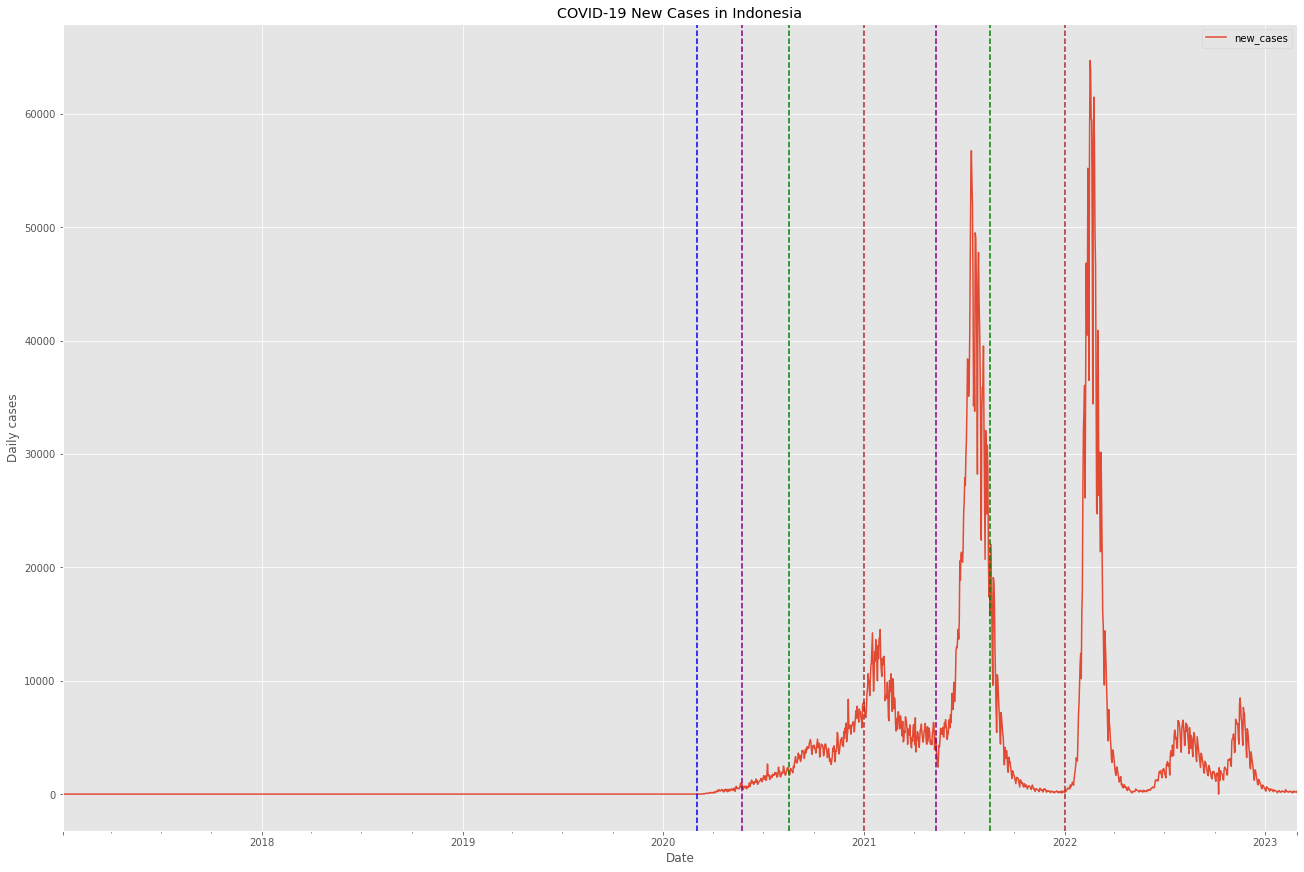

In [38]:
# COVID-19 daily cases plot
fig, ax = plt.subplots(constrained_layout = True)
covid_data_expanded.set_index('date_reported').plot(ax = ax, 
                                                    figsize = (18,12))

# First date COVID discovery in Indonesia
ax.axvline(x = "2020-03-02", 
           color = 'blue', 
           linestyle = '--')

# 2020 Eid Al-Fitr
ax.axvline(x = "2020-05-23", 
           color = 'purple', 
           linestyle = '--') 

# Indonesia's Independence Day
ax.axvline(x = "2020-08-17", 
           color = 'green', 
           linestyle = '--') 

# 2021 New Year
ax.axvline(x = "2021-01-01", 
           color = 'brown', 
           linestyle = '--')

# 2021 Eid Al-Fitr
ax.axvline(x = "2021-05-12", 
           color = 'purple', 
           linestyle = '--') 

# Indonesia's Independence Day
ax.axvline(x = "2021-08-17", 
           color = 'green', 
           linestyle = '--') 

# 2022 New Year
ax.axvline(x = "2022-01-01", 
           color = 'brown', 
           linestyle = '--') 

ax.set_ylabel("Daily cases")
ax.set_xlabel("Date")
ax.set_title('COVID-19 New Cases in Indonesia')

Text(0.5, 1.0, 'COVID-19 New Cases in Indonesia')

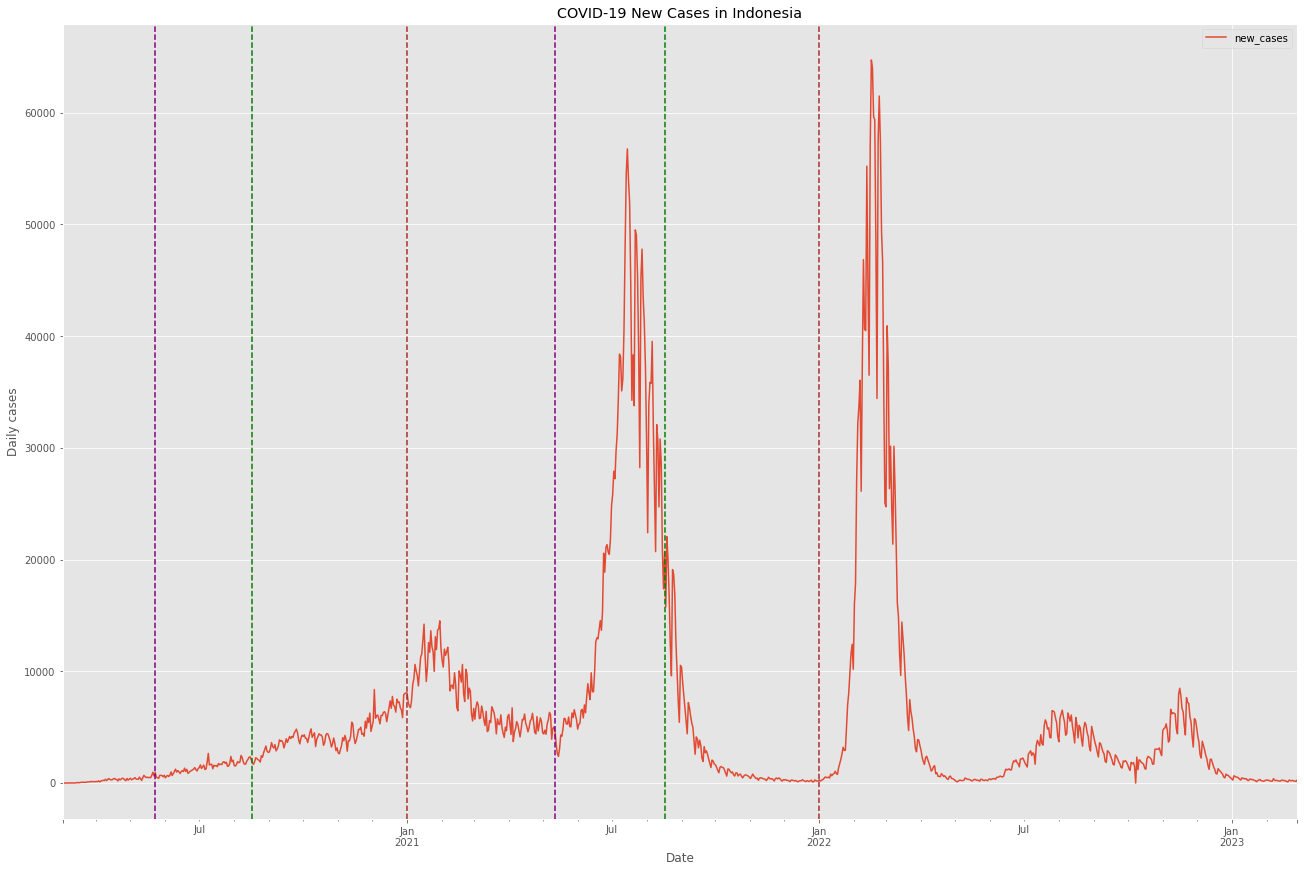

In [39]:
# COVID-19 daily cases plot
fig, ax = plt.subplots(constrained_layout = True)
covid_data_expanded.set_index('date_reported')["2020-03-02":].plot(ax = ax, 
                                                                   figsize = (18,12))

# First date COVID discovery in Indonesia
ax.axvline(x = "2020-03-02", 
           color = 'blue', 
           linestyle = '--')

# 2020 Eid Al-Fitr
ax.axvline(x = "2020-05-23", 
           color = 'purple', 
           linestyle = '--') 

# Indonesia's Independence Day
ax.axvline(x = "2020-08-17", 
           color = 'green', 
           linestyle = '--') 

# 2021 New Year
ax.axvline(x = "2021-01-01", 
           color = 'brown', 
           linestyle = '--')

# 2021 Eid Al-Fitr
ax.axvline(x = "2021-05-12", 
           color = 'purple', 
           linestyle = '--') 

# Indonesia's Independence Day
ax.axvline(x = "2021-08-17", 
           color = 'green', 
           linestyle = '--') 

# 2022 New Year
ax.axvline(x = "2022-01-01", 
           color = 'brown', 
           linestyle = '--') 

ax.set_ylabel("Daily cases")
ax.set_xlabel("Date")
ax.set_title('COVID-19 New Cases in Indonesia')

From the graphs above, we can see that:
1. There is a significant **increment** on daily cases, especially **2-4 weeks after New Year's Holiday**, because people's mobility during holiday is very high, and will most likely spread the virus.
2. Significant **increment** trend is also found not long **after Eid Fitri Holiday**, since the majority of Indonesian are Muslim, and usually people go back to their hometown on such occassion, making certain locations are crowded, and the virus will most likely to spread.

## Currency Exchange

In this analysis, we will use the 'Close' feature, as

1. 'Close' price reflects all of the information available to all market participants (especially institutional market participants who have more accurate information) at the end of trading the stock.
2. (especially for hedge funds or mutual fund managers) the close price is a determinant of the performance and wealth of investors for the day.
3. 'Close' price reflects the price position at which the investor dares to hold a position, in the face of all information that may occur at night, when there is no trade.
4. More than 90% of technical indicators used by technical analysts use close prices as their main input. This causes the position of the price to close, can trigger a buy signal or a sell signal.

Source : https://sahamology.id/arti-harga-open-harga-high-harga-low-dan-harga-close-dalam-analisis-teknikal/

In [40]:
# IDR/USD
idr_usd = idr_usd[['date', 'close']]

# IDR/JPY
idr_jpy = idr_jpy[['date', 'close']]

Text(0.5, 1.0, 'IDR/JPY Currency Exchange 2017 - 2022')

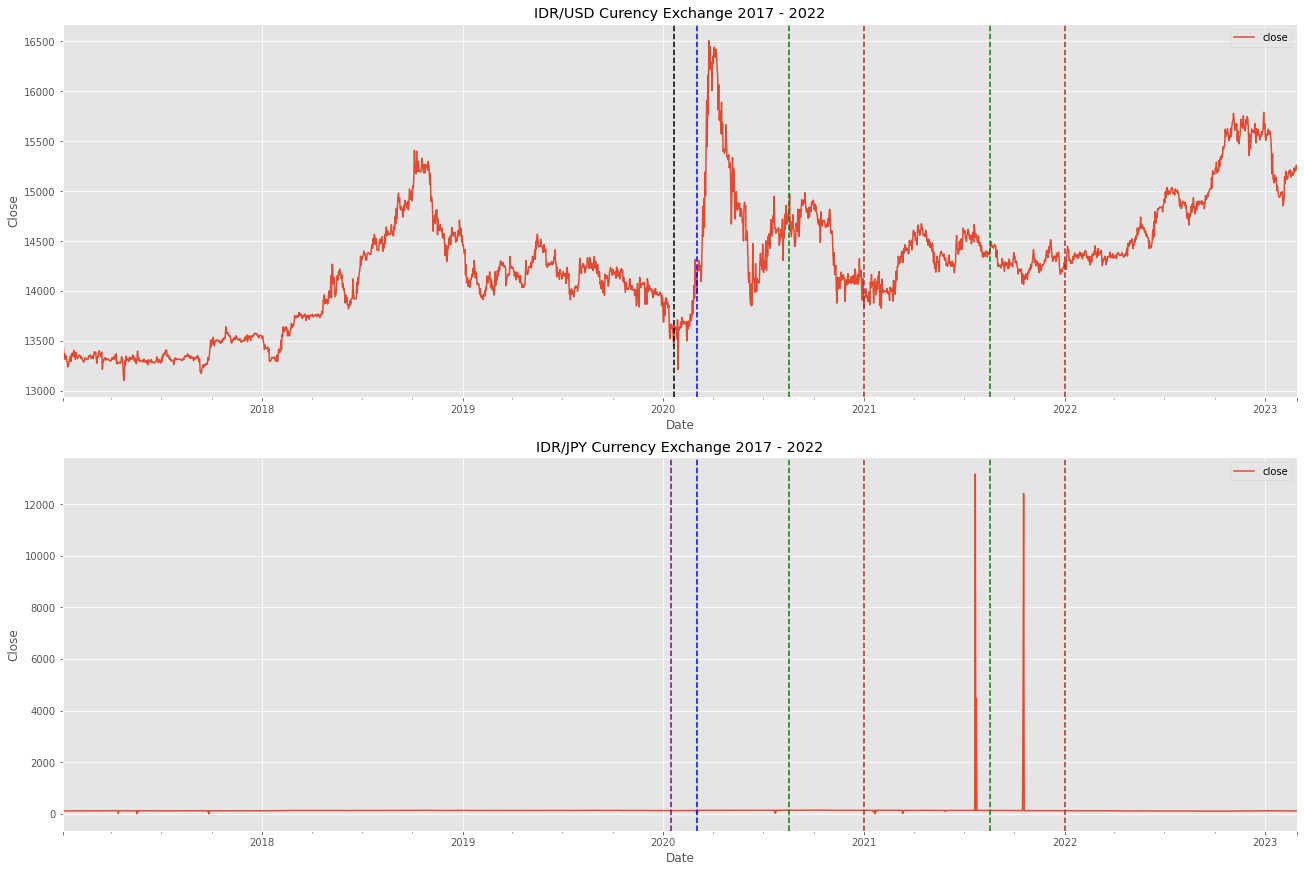

In [41]:
# Indonesia's Currency Exchange plot
fig, (ax1, ax2) = plt.subplots(2,1, constrained_layout = True)
idr_usd.set_index('date').plot(ax = ax1, 
                               figsize = (18,12))

idr_jpy.set_index('date').plot(ax = ax2, 
                               figsize = (18,12))

# First date COVID discovery
ax1.axvline(x = "2020-03-02", 
            color = 'blue', 
            linestyle = '--') # in Indonesia

ax2.axvline(x = "2020-03-02", 
            color = 'blue', 
            linestyle = '--') # in Indonesia

ax1.axvline(x = "2020-01-20", 
            color = 'black', 
            linestyle = '--') # in USA

ax2.axvline(x = "2020-01-16", 
            color = 'purple', 
            linestyle = '--') # in Japan

# Indonesia's Independence Day
ax1.axvline(x = "2020-08-17", 
            color = 'green', 
            linestyle = '--') 

ax2.axvline(x = "2020-08-17", 
            color = 'green', 
            linestyle = '--')

# 2021 New Year
ax1.axvline(x = "2021-01-01", 
            color = 'brown', 
            linestyle = '--') 

ax2.axvline(x = "2021-01-01", 
            color = 'brown', 
            linestyle = '--')

# Indonesia's Independence Day
ax1.axvline(x = "2021-08-17", 
            color = 'green', 
            linestyle = '--') 

ax2.axvline(x = "2021-08-17", 
            color = 'green', 
            linestyle = '--')

# 2022 New Year
ax1.axvline(x = "2022-01-01", 
            color = 'brown', 
            linestyle = '--') 

ax2.axvline(x = "2022-01-01", 
            color = 'brown', 
            linestyle = '--')

ax1.set_ylabel("Close")
ax2.set_ylabel("Close")

ax1.set_xlabel("Date")
ax2.set_xlabel("Date")

ax1.set_title('IDR/USD Curency Exchange 2017 - 2022')
ax2.set_title('IDR/JPY Currency Exchange 2017 - 2022')

It seems that there are outliers in the data, but we will **let them** as it is in this analysis. Since it is probably happen because of an **error in the system**.

### Post COVID-19 Discovery

Text(0.5, 1.0, 'IDR/JPY Currency Exchange 2017 - 2022')

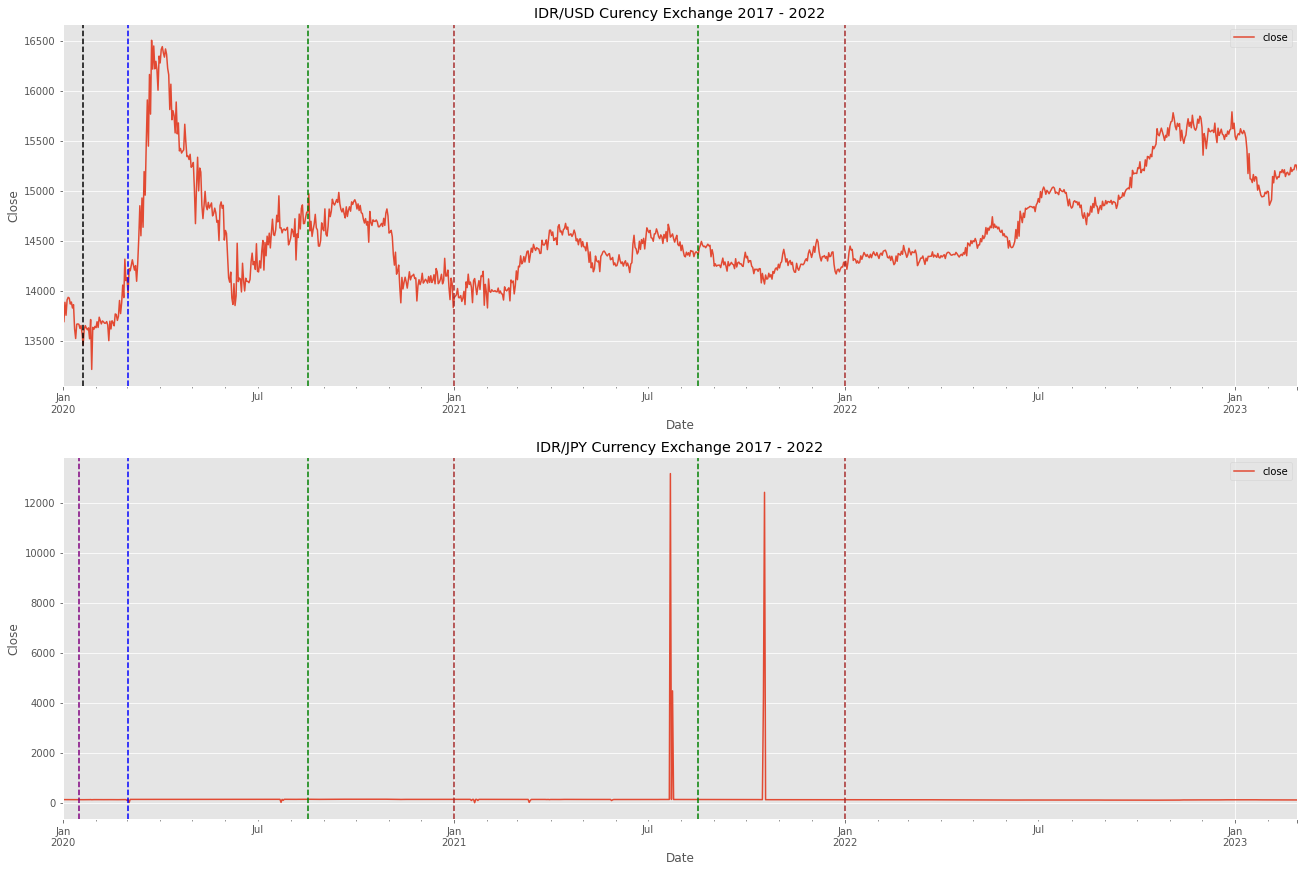

In [42]:
# Indonesia's Currency Exchange plot
fig, (ax1, ax2) = plt.subplots(2,1, constrained_layout = True)
idr_usd.set_index('date')["2020-01-01":].plot(ax = ax1, 
                                              figsize = (18,12))

idr_jpy.set_index('date')["2020-01-01":].plot(ax = ax2, 
                                              figsize = (18,12))

# First date COVID discovery
ax1.axvline(x = "2020-03-02", 
            color = 'blue', 
            linestyle = '--') # in Indonesia

ax2.axvline(x = "2020-03-02", 
            color = 'blue', 
            linestyle = '--') # in Indonesia

ax1.axvline(x = "2020-01-20", 
            color = 'black', 
            linestyle = '--') # in USA

ax2.axvline(x = "2020-01-16", 
            color = 'purple', 
            linestyle = '--') # in Japan

# Indonesia's Independence Day
ax1.axvline(x = "2020-08-17", 
            color = 'green', 
            linestyle = '--') 

ax2.axvline(x = "2020-08-17", 
            color = 'green', 
            linestyle = '--')

# 2021 New Year
ax1.axvline(x = "2021-01-01", 
            color = 'brown', 
            linestyle = '--') 

ax2.axvline(x = "2021-01-01", 
            color = 'brown', 
            linestyle = '--')

# Indonesia's Independence Day
ax1.axvline(x = "2021-08-17", 
            color = 'green', 
            linestyle = '--') 

ax2.axvline(x = "2021-08-17", 
            color = 'green', 
            linestyle = '--')

# 2022 New Year
ax1.axvline(x = "2022-01-01", 
            color = 'brown', 
            linestyle = '--') 

ax2.axvline(x = "2022-01-01", 
            color = 'brown', 
            linestyle = '--')

ax1.set_ylabel("Close")
ax2.set_ylabel("Close")

ax1.set_xlabel("Date")
ax2.set_xlabel("Date")

ax1.set_title('IDR/USD Curency Exchange 2017 - 2022')
ax2.set_title('IDR/JPY Currency Exchange 2017 - 2022')

# Stock Market Price

By the same argument as the 'Currency Exchange' section, we will also use the 'Close' feature in this analysis.

In [43]:
# BBCA.JK
bbca_info = bbca_info[['date', 'close']]

# CMPP.JK
jkse_info = jkse_info[['date', 'close']]

Text(0.5, 1.0, '^JKSE Stock Price 2017 - 2022')

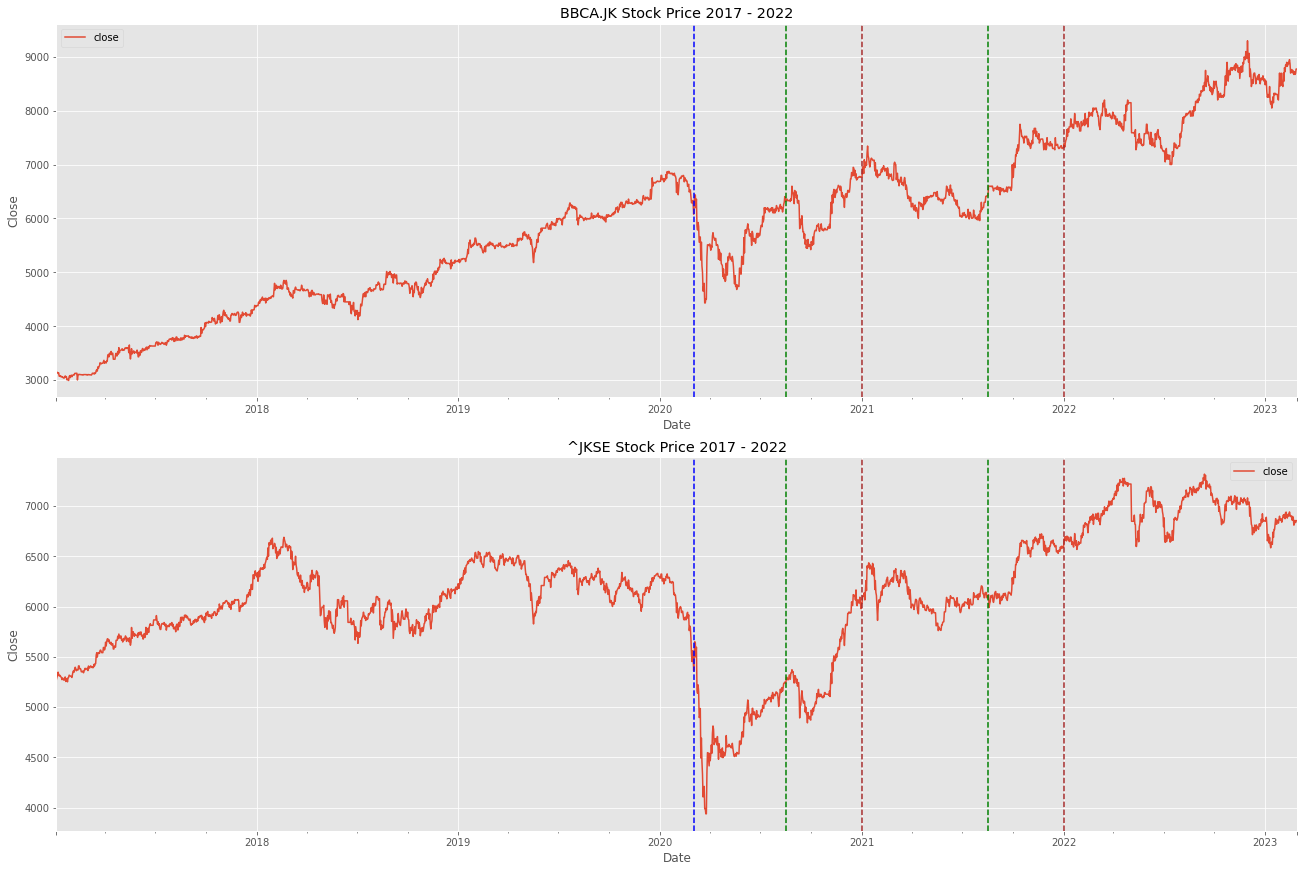

In [44]:
# Stock market price plot
fig, (ax1, ax2) = plt.subplots(2,1, constrained_layout = True)
bbca_info.set_index('date').plot(ax = ax1, 
                                 figsize = (18,12))

jkse_info.set_index('date').plot(ax = ax2, 
                                 figsize = (18,12))

# First date COVID discovery in Indonesia
ax1.axvline(x = "2020-03-02", 
            color = 'blue', 
            linestyle = '--') 

ax2.axvline(x = "2020-03-02", 
            color = 'blue', 
            linestyle = '--')

# Indonesia's Independence Day
ax1.axvline(x = "2020-08-17", 
            color = 'green',
            linestyle = '--') 

ax2.axvline(x = "2020-08-17",
            color = 'green', 
            linestyle = '--')

# 2021 New Year
ax1.axvline(x = "2021-01-01", 
            color = 'brown', 
            linestyle = '--') 

ax2.axvline(x = "2021-01-01", 
            color = 'brown', 
            linestyle = '--')

# Indonesia's Independence Day
ax1.axvline(x = "2021-08-17",
            color = 'green', 
            linestyle = '--') 

ax2.axvline(x = "2021-08-17", 
            color = 'green',
            linestyle = '--')

# 2022 New Year
ax1.axvline(x = "2022-01-01", 
            color = 'brown', 
            linestyle = '--') 

ax2.axvline(x = "2022-01-01", 
            color = 'brown', 
            linestyle = '--')

ax1.set_ylabel("Close")
ax2.set_ylabel("Close")

ax1.set_xlabel("Date")
ax2.set_xlabel("Date")

ax1.set_title('BBCA.JK Stock Price 2017 - 2022')
ax2.set_title('^JKSE Stock Price 2017 - 2022')

### Post COVID-19 Discovery

Text(0.5, 1.0, '^JKSE Stock Price post COVID-19 Discovery in Indonesia')

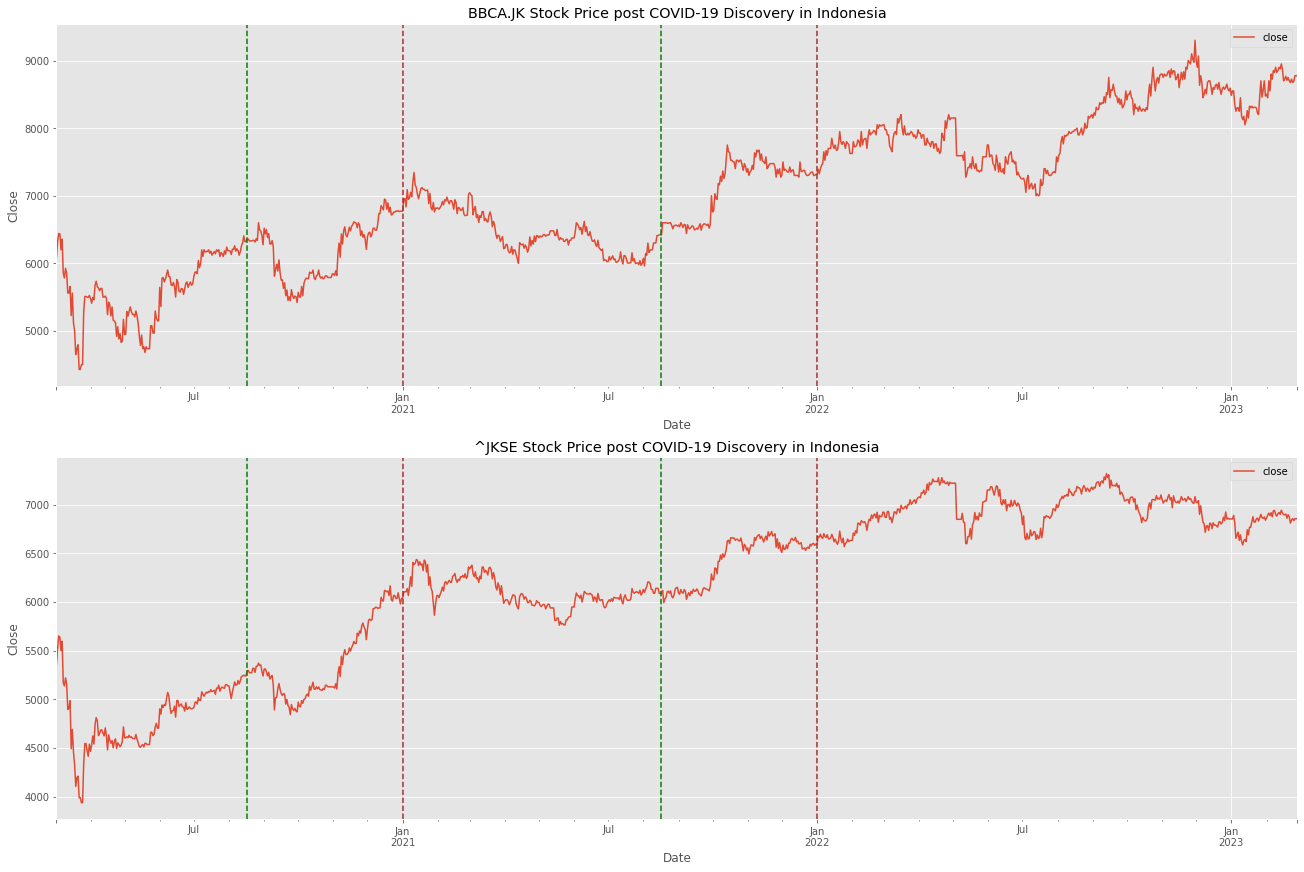

In [45]:
# Stock market price post COVID plot
fig, (ax1, ax2) = plt.subplots(2,1, constrained_layout = True)
bbca_info.set_index('date')["2020-03-02":].plot(ax = ax1, 
                                                figsize = (18,12))

jkse_info.set_index('date')["2020-03-02":].plot(ax = ax2, 
                                                figsize = (18,12))

# First date COVID discovery in Indonesia
ax1.axvline(x = "2020-03-02", 
            color = 'blue', 
            linestyle = '--') 

ax2.axvline(x = "2020-03-02", 
            color = 'blue', 
            linestyle = '--')

# Indonesia's Independence Day
ax1.axvline(x = "2020-08-17", 
            color = 'green', 
            linestyle = '--') 

ax2.axvline(x = "2020-08-17", 
            color = 'green', 
            linestyle = '--')

# 2021 New Year
ax1.axvline(x = "2021-01-01", 
            color = 'brown', 
            linestyle = '--') 

ax2.axvline(x = "2021-01-01", 
            color = 'brown', 
            linestyle = '--')

# Indonesia's Independence Day
ax1.axvline(x = "2021-08-17",
            color = 'green', 
            linestyle = '--') 

ax2.axvline(x = "2021-08-17", 
            color = 'green',
            linestyle = '--')

# 2022 New Year
ax1.axvline(x = "2022-01-01",
            color = 'brown', 
            linestyle = '--') 

ax2.axvline(x = "2022-01-01",
            color = 'brown', 
            linestyle = '--')

ax1.set_ylabel("Close")
ax2.set_ylabel("Close")

ax1.set_xlabel("Date")
ax2.set_xlabel("Date")

ax1.set_title('BBCA.JK Stock Price post COVID-19 Discovery in Indonesia')
ax2.set_title('^JKSE Stock Price post COVID-19 Discovery in Indonesia')

From the graphs above, we can see that:
1. On the **first 3-4 weeks of COVID-19 discovery in Indonesia**, the price of BBCA.JK and ^JKSE stock market went **down** for **31.21%** and **30.31%**, respecively, and managed to recover since the first two weeks of April 2020.
2. **2-3 weeks after Indonesia's Independence day in 2020**, there was also a **decremental** trend for both stock market price, and it went down for **8.65%** and **7.62%** , respectively. But these stock prices recovered since October 2020.
3. Not long after **2021' New Year's Eve**, there is also a **decremental** trend for both stock market price, and it went down for **15.37%** and **3.42%**, respectively, and did not show any sign of recovery until October 2021.
4. Surprisingly, both stock market prices give an **incremental** trend starting from **October in 2020 and 2021**.

# Hypothesis Testing

We will see if any pair of these datasets correlate with each other by using hypothesis testing with 0.05 significance level.

## Economic Datasets

Notice that there are datasets which start from 2017-01-02, and there is also datasets which start from 2017-01-03. For consistency, we will drop the data on 2017-01-02 and start the index from 2017-01-03.

In [46]:
idr_usd = idr_usd.set_index('date')['2017-01-03':]

idr_jpy = idr_jpy.set_index('date')['2017-01-03':]

bbca_info = bbca_info.set_index('date')['2017-01-03':]

jkse_info = jkse_info.set_index('date')['2017-01-03':]

In [47]:
df = pd.DataFrame()
df.index = idr_usd.index
df['idr_usd'] = idr_usd.values
df['idr_jpy'] = idr_jpy.values
df['bbca_info'] = bbca_info.values
df['jkse_info'] = jkse_info.values

significance_level = 0.05
print('Significance level = 0.05 \n')

temp = pd.DataFrame()
features = []
correlations = []
p_values = []
conclusions = []
for col in df.columns:
    for sub_col in df.columns:
        if col != sub_col:
            r, p = pearsonr(df.dropna()[col], df.dropna()[sub_col])
            
            features.append(f'{col} vs. {sub_col}')
            correlations.append(r)
            p_values.append(p)
            
            if p < significance_level:
                conclusions.append('Reject H0')
                
            else:
                conclusions.append('Do not reject H0')

        else:
            pass
        
temp['features'] = features
temp['correlations'] = correlations
temp['p_values'] = p_values
temp['conclusions'] = conclusions

temp

Significance level = 0.05 



,features,correlations,p_values,conclusions
0,idr_usd vs. idr_jpy,0.005127,8.080591e-01,Do not reject H0
1,idr_usd vs. bbca_info,0.624731,1.333505e-243,Reject H0
2,idr_usd vs. jkse_info,0.116396,3.122353e-08,Reject H0
3,idr_jpy vs. idr_usd,0.005127,8.080591e-01,Do not reject H0
4,idr_jpy vs. bbca_info,0.019713,3.501860e-01,Do not reject H0
5,idr_jpy vs. jkse_info,0.005676,7.879709e-01,Do not reject H0
6,bbca_info vs. idr_usd,0.624731,1.333505e-243,Reject H0
7,bbca_info vs. idr_jpy,0.019713,3.501860e-01,Do not reject H0
8,bbca_info vs. jkse_info,0.612116,2.868541e-231,Reject H0
9,jkse_info vs. idr_usd,0.116396,3.122353e-08,Reject H0


Based on the hypothesis testing result, we can conclude that **IDR/USD** **moderately correlates** with both BBCA dataset, with pearson coefficient of 0.624731. In addition, BBCA dataset also **moderately correlates** with both ^JKSE dataset, with pearson coefficient of 0.612116, while the other pair datasets do not correlate with each other, using significance level of 0.05.

**Note**: IDR/USD and ^JKSE datasets do correlate with each other as its p-value is significant, but put in mind that its pearson coefficient is **close to 0**. And such, we will **treat** it as they **do not correlate** with each other.

## vs. COVID Data

In [48]:
covid_data = covid_data.set_index('date_reported')

In [49]:
idr_usd = idr_usd.reset_index()
idr_usd_covid = idr_usd.set_index('date')['2020-01-03':covid_data.index[-1].strftime('%Y-%m-%d')]
idr_usd_covid = idr_usd_covid.reset_index()
idr_usd = idr_usd.set_index('date')

idr_jpy = idr_jpy.reset_index()
idr_jpy_covid = idr_jpy.set_index('date')['2020-01-03':covid_data.index[-1].strftime('%Y-%m-%d')]
idr_jpy_covid = idr_jpy_covid.reset_index()
idr_jpy = idr_jpy.set_index('date')

bbca_info = bbca_info.reset_index()
bbca_info_covid = bbca_info.set_index('date')['2020-01-03':covid_data.index[-1].strftime('%Y-%m-%d')]
bbca_info_covid = bbca_info_covid.reset_index()
bbca_info = bbca_info.set_index('date')

jkse_info = jkse_info.reset_index()
jkse_info_covid = jkse_info.set_index('date')['2020-01-03':covid_data.index[-1].strftime('%Y-%m-%d')]
jkse_info_covid = jkse_info_covid.reset_index()
jkse_info = jkse_info.set_index('date')

In [50]:
df = pd.DataFrame()
df.index = covid_data.index
df['covid'] = covid_data['new_cases'].values
df['idr_usd'] = idr_usd_covid['close'].values
df['idr_jpy'] = idr_jpy_covid['close'].values
df['bbca_info'] = bbca_info_covid['close'].values
df['jkse_info'] = jkse_info_covid['close'].values

significance_level = 0.05
print('Significance level = 0.05 \n')

temp = pd.DataFrame()
features = []
correlations = []
p_values = []
conclusions = []
for col in df.columns:
    for sub_col in df.columns:
        if col != sub_col:
            r, p = pearsonr(df.dropna()[col], df.dropna()[sub_col])
            
            features.append(f'{col} vs. {sub_col}')
            correlations.append(r)
            p_values.append(p)
            
            if p < significance_level:
                conclusions.append('Reject H0')
                
            else:
                conclusions.append('Do not reject H0')

        else:
            pass
        
temp['features'] = features
temp['correlations'] = correlations
temp['p_values'] = p_values
temp['conclusions'] = conclusions

temp

Significance level = 0.05 



,features,correlations,p_values,conclusions
0,covid vs. idr_usd,-0.144460,8.400820e-07,Reject H0
1,covid vs. idr_jpy,0.103373,4.385177e-04,Reject H0
2,covid vs. bbca_info,-0.028932,3.263178e-01,Do not reject H0
3,covid vs. jkse_info,0.101311,5.705345e-04,Reject H0
4,idr_usd vs. covid,-0.144460,8.400820e-07,Reject H0
5,idr_usd vs. idr_jpy,-0.033406,2.570445e-01,Do not reject H0
6,idr_usd vs. bbca_info,0.212274,3.257807e-13,Reject H0
7,idr_usd vs. jkse_info,0.003779,8.980052e-01,Do not reject H0
8,idr_jpy vs. covid,0.103373,4.385177e-04,Reject H0
9,idr_jpy vs. idr_usd,-0.033406,2.570445e-01,Do not reject H0


In [51]:
df

,covid,idr_usd,idr_jpy,bbca_info,jkse_info
date_reported,,,,,
2020-01-03,0,13884.786133,127.906448,6800.000000,6323.465820
2020-01-04,0,13754.796549,126.566427,6800.000000,6323.465820
2020-01-05,0,13909.350911,128.488373,6718.333333,6254.145020
2020-01-06,0,13934.316406,129.048325,6735.000000,6257.402832
2020-01-07,0,13926.500000,128.111115,6740.000000,6279.346191
...,...,...,...,...,...
2023-02-24,236,15210.000000,112.977142,8675.000000,6856.576172
2023-02-25,182,15211.666667,112.819255,8691.666667,6835.332682
2023-02-26,177,15257.700195,111.800697,8775.000000,6854.776855


# Model Identification

In this project, for simplicity purposes, we will only focus on performing TSA on the BBCA data. If you want to perform TSA on another data, then just repeat the process and apply it to the data you want to perform TSA.

In particular, these dataset is chosen since it is a financial data, so it has high volatility, and one of our aim here is to compare base model with ARCH/GARCH model. In addition, from the previous section, we know that BBCA dataset moderately/strongly correlate with other datasets, and we will use ARIMAX model with the other dataset as the exogenous arguments to predict the BBCA dataset.

## Check Stationary

To perform TSA, the data itself **has to be a stationary data** as its statistical properties do not change over time. The assumption in time series data modeling is that each observation is independent of each other.

In [52]:
bbca_info = bbca_info['2020-04-01':]

<Figure size 1296x864 with 0 Axes>

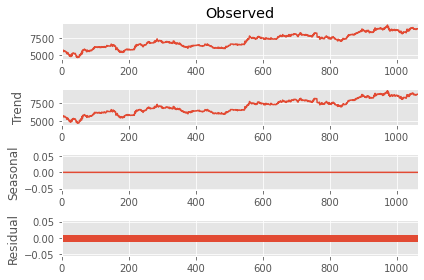

In [53]:
plt.figure(figsize = (18,12))

additive_result = seasonal_decompose(bbca_info.values, model = 'additive', period = 1)
additive_result.plot()
plt.show()

<Figure size 1296x864 with 0 Axes>

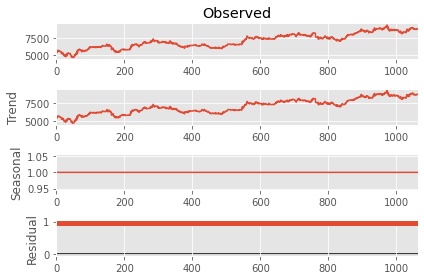

In [54]:
plt.figure(figsize = (18,12))

multiplicative_result = seasonal_decompose(bbca_info.values, model = 'multiplicative', period = 1)
multiplicative_result.plot()
plt.show()

In particular, we had observe from the the graph above that our dataset has **increment trend** (additive, in particular, as the multiplicative residual are high. But we will see this in further section). Thus, it **should be not stationer**. We will check this claim by **ADF-Test using significance level 95%** ($\alpha$ = 0.05) and from its **ACF/PACF Plot**.

In [55]:
# Test
test = adfuller(bbca_info['close'])

# Statistic result
print('Augmented-Dickey Fuller Result :', test[0])

# p-value
print('p-value :', test[1])

Augmented-Dickey Fuller Result : -1.082843860741808
p-value : 0.7218648608403077


C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


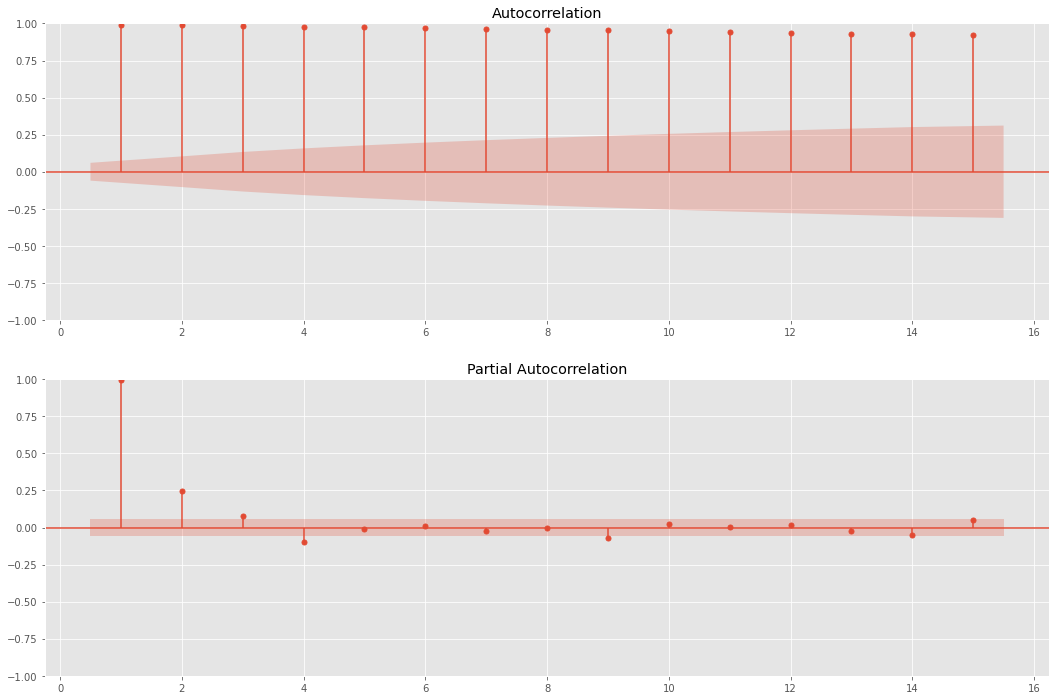

In [56]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, 
                               figsize = (18,12))
 
# ACF Plot from stock market price data
plot_acf(bbca_info, 
         lags = 15, 
         zero = False,
         ax = ax1)

# PACF Plot from stock market price data
plot_pacf(bbca_info, 
          lags = 15, 
          zero = False, 
          ax = ax2)

plt.show()

Based on the hypothesis testing result above, we can conclude that the BBCA dataset is **not stationary**, as its **p-value** is **higher** than the $\alpha$. And then, also notice that it has **no significant** change in the **ACF** plot. So, we will perform **differentiation** on this dataset.

## Convert into Stationer Data

If the data is not stationary, it is necessary to transform the data. One of the transformation methods is to use the **differentiation method**.

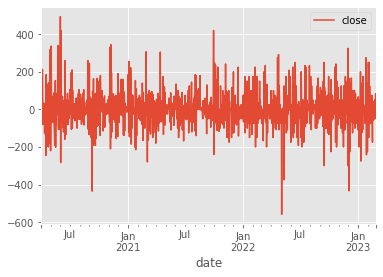

In [57]:
# Differentiation
bbca_info_diff = bbca_info.diff().dropna()

# Differentiation result plotting
bbca_info_diff.plot()
plt.show()

In [58]:
# Adfuller Test
test_1 = adfuller(bbca_info_diff['close'])

# Statistic result
print('Augmented-Dickey Fuller Result :', test_1[0])

# p-value
print('p-value :', test_1[1])

Augmented-Dickey Fuller Result : -15.606128262348674
p-value : 1.8037799727844874e-28


Since the p-value is already lower than the $\alpha$, then it means that the BBCA dataset is now stationary.

# Model Estimation

To decide the order of p and q in the ARIMA model, i.e. estimating the most suitable model for the data, there are 2 steps that we can do:

1. **Manual**: Analyze the ACF and PACF plot and look at which lag the cut off happen to determine the p and q then look for the least AIC and BIC model.

2. **Auto**: Use automated iterative steps to look for the model with the least AIC for the given range of p and q using pmdarima package.

For simplicity, here we will only use the **Auto method** and will only look for the least **AIC** model. Here, AIC criteria is chosen because in financial datasets, the volatility is high, and considering the **unpredicted external factors** (e.g. COVID-19), there will **not** be a **fixed/final model** in such cases.

## Automation Method (Auto-ARIMA)

### Best Model Estimation

In [59]:
# Get best ARIMA model with lowest AIC
results_auto_arima_bbca = pm.auto_arima(bbca_info, 
                                        start_p = 0,
                                        start_q = 0,
                                        max_p = 10,
                                        max_q = 10,
                                        d = None,
                                        trace = True,
                                        error_action = 'ignore')

results_auto_arima_bbca.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12867.341, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12740.241, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12735.847, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12866.310, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12731.713, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12717.584, Time=0.63 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12722.692, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=12703.991, Time=0.54 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=12709.016, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=12705.747, Time=0.78 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=12705.781, Time=0.84 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12707.420, Time=0.49 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=12704.656, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=12706.418, Time=0.66 sec
 ARIMA(3,1,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1064
Model:               SARIMAX(3, 1, 1)   Log Likelihood               -6346.791
Date:                Fri, 03 Mar 2023   AIC                          12703.583
Time:                        09:49:47   BIC                          12728.427
Sample:                             0   HQIC                         12712.997
                               - 1064                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1487      0.129      1.149      0.251      -0.105       0.402
ar.L2          0.1116      0.051      2.183      0.029       0.011       0.212
ar.L3          0.1951      0.028      6.949      0.000       0.140       0.250
ma.L1         -0.5248      0.131     -3.997      0.000      -0.782      -0.267
sigma2      9030.1455    237.393     38.039      0.000    8564.863    9495.428
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               588.58
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.30
Prob(H) (two-sided):                  0.92   Kurtosis:                         6.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Based on the summary table above, we can see that the **ARIMA(3,1,1)** and **ARIMA(4,1,0)** have the **lowest AICs**. Thus, we will try to analyze the performance of that model by using **diagnostic test**. If it is not suited to be a predictor model, we will pick another model (iteratively).

### ARIMA(3,1,1)

In [60]:
model_1a_bbca = SARIMAX(bbca_info, 
                        order = (3,1,1))

results_1a_bbca = model_1a_bbca.fit()

results_1a_bbca.summary()

C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 1064
Model:               SARIMAX(3, 1, 1)   Log Likelihood               -6346.791
Date:                Fri, 03 Mar 2023   AIC                          12703.583
Time:                        09:49:47   BIC                          12728.427
Sample:                    04-01-2020   HQIC                         12712.997
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1487      0.129      1.149      0.251      -0.105       0.402
ar.L2          0.1116      0.051      2.183      0.029       0.011       0.212
ar.L3          0.1951      0.028      6.949      0.000       0.140       0.250
ma.L1         -0.5248      0.131     -3.997      0.000      -0.782      -0.267
sigma2      9030.1455    237.393     38.039      0.000    8564.863    9495.428
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               588.58
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.30
Prob(H) (two-sided):                  0.92   Kurtosis:                         6.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Conclusion**

----

Notice that even without doing diagnostic test (i.e. Ljung Box Test), we can already see that the **parameters** of this model are **not statistically significant**. Thus, we will not use this model for our forecasting task.

### ARIMA(4,1,0)

In [61]:
model_1b_bbca = SARIMAX(bbca_info, 
                        order = (4,1,0))

results_1b_bbca = model_1b_bbca.fit()

results_1b_bbca.summary()

C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 1064
Model:               SARIMAX(4, 1, 0)   Log Likelihood               -6347.210
Date:                Fri, 03 Mar 2023   AIC                          12704.420
Time:                        09:49:47   BIC                          12729.264
Sample:                    04-01-2020   HQIC                         12713.834
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3749      0.027    -13.765      0.000      -0.428      -0.322
ar.L2         -0.0789      0.030     -2.660      0.008      -0.137      -0.021
ar.L3          0.1519      0.029      5.170      0.000       0.094       0.209
ar.L4          0.0790      0.026      3.031      0.002       0.028       0.130
sigma2      8975.6866    235.674     38.085      0.000    8513.774    9437.600
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               582.56
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.29
Prob(H) (two-sided):                  0.81   Kurtosis:                         6.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
arima_resid = results_1b_bbca.resid
white_noise_arima = acorr_ljungbox(arima_resid ** 2, lags = [10], return_df = True)
white_noise_arima

,lb_stat,lb_pvalue
10,0.00213,1.0


**Diagnostic Test & Conclusion**

**Ljung-Box**

----

$H_0$ = Error term is white noise

$H_1$ = Error term is not white noise

Based on the table above, get that the p-value for Ljung-Box statistical test is 0.01. Since p-value = 0.01 < 0.05 = $\alpha$, we **reject our null hypothesis**. Thus, we conclude that our **residuals** are **not independently distributed** using significance level of 0.05. 

**Conclusion**

----

Based on the hypothesis testing and the model summary above, we can conclude that the residual from our ARIMA(4,1,0) is **not white noise**, based on significance level of 0.05. Thus, we **will** conduct GARCH to fit our model.

### Final Model

In [63]:
arima_model = SARIMAX(bbca_info, 
                      order = (4,1,0)).fit()

arima_resid = arima_model.resid

C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


## ARIMAX Model

Next, since we know that BBCA datasets moderately/strongly correlate with other datasets, we will try to use the other as the exogenous arguments to predict our BBCA dataset. In this case, we will use **only IDR/USD** dataset as our **exogenous argument**. JKSE dataset is not included since both are stock market dataset, and it is not a wise choice to use dataset with the same 'type' as the exogenous argument. In the other hand, COVID dataset is not used since it has different starting point, and if we want to use it as our exogenous argument, we have to cut our BBCA dataset, which will cause a huge loss information, not considering that COVID is only temporary.

In [64]:
# Fetch other datasets and 'merge' it into BBCA dataset
exog_idr_usd = pd.DataFrame()
exog_idr_usd.index = bbca_info.index
exog_idr_usd['close'] = idr_usd['2020-04-01':]['close']

exog_idr_usd

,close
date,
2020-04-01,16277.943359
2020-04-02,16412.808594
2020-04-03,16441.263672
2020-04-04,16377.338542
2020-04-05,16335.882812
...,...
2023-02-24,15210.000000
2023-02-25,15211.666667
2023-02-26,15257.700195


### Best Model Estimation

In [65]:
# Get best ARIMAX model with lowest AIC
results_auto_arimax_bbca = pm.auto_arima(bbca_info, 
                                         start_p = 0,
                                         start_q = 0,
                                         max_p = 10,
                                         max_q = 10,
                                         d = None,
                                         exog = exog_idr_usd.values,
                                         trace = True,
                                         error_action = 'ignore')

results_auto_arimax_bbca.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12867.341, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12740.241, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12735.847, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12866.310, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12731.713, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12717.584, Time=0.61 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12722.692, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=12703.991, Time=0.54 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=12709.016, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=12705.747, Time=0.74 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=12705.781, Time=0.80 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12707.420, Time=0.46 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=12704.656, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=12706.418, Time=0.62 sec
 ARIMA(3,1,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1064
Model:               SARIMAX(3, 1, 1)   Log Likelihood               -6346.791
Date:                Fri, 03 Mar 2023   AIC                          12703.583
Time:                        09:49:54   BIC                          12728.427
Sample:                             0   HQIC                         12712.997
                               - 1064                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1487      0.129      1.149      0.251      -0.105       0.402
ar.L2          0.1116      0.051      2.183      0.029       0.011       0.212
ar.L3          0.1951      0.028      6.949      0.000       0.140       0.250
ma.L1         -0.5248      0.131     -3.997      0.000      -0.782      -0.267
sigma2      9030.1455    237.393     38.039      0.000    8564.863    9495.428
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               588.58
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.30
Prob(H) (two-sided):                  0.92   Kurtosis:                         6.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Based on the summary table above, we can see that as the previous ones, the **ARIMAX(3,1,1,'IDR/USD')** and **ARIMAX(4,1,0,'IDR/USD')** have the **lowest AICs**. Thus, we will try to analyze the performance of that model by using **diagnostic test**. If it is not suited to be a predictor model, we will pick another model (iteratively).

### ARIMAX(3,1,1,'IDR/USD')

In [66]:
# Model ARIMAX(2,1,2,'IDR/USD')
model_2a_bbca = SARIMAX(bbca_info, 
                        order = (3,1,1),
                        exog = exog_idr_usd.values)

results_2a_bbca = model_2a_bbca.fit()

results_2a_bbca.summary()

C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 1064
Model:               SARIMAX(3, 1, 1)   Log Likelihood               -6344.670
Date:                Fri, 03 Mar 2023   AIC                          12701.339
Time:                        09:49:54   BIC                          12731.153
Sample:                    04-01-2020   HQIC                         12712.637
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0712      0.031     -2.275      0.023      -0.133      -0.010
ar.L1          0.1401      0.131      1.069      0.285      -0.117       0.397
ar.L2          0.1083      0.052      2.094      0.036       0.007       0.210
ar.L3          0.1945      0.028      6.912      0.000       0.139       0.250
ma.L1         -0.5179      0.133     -3.906      0.000      -0.778      -0.258
sigma2      8949.5678    234.018     38.243      0.000    8490.902    9408.234
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               587.36
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.29
Prob(H) (two-sided):                  0.86   Kurtosis:                         6.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Conclusion**

----

Notice that even without doing diagnostic test (i.e. Ljung-Box Test), we can already see that the **parameters** of this model are **not statistically significant**. Thus, we will not use this model for our forecasting task.

### ARIMAX(4,1,0,'IDR/USD')

In [67]:
# Model ARIMAX(4,1,0,'IDR/USD')
model_2b_bbca = SARIMAX(bbca_info, 
                       order = (4,1,0),
                       exog = exog_idr_usd.values)

results_2b_bbca = model_2b_bbca.fit()

results_2b_bbca.summary()

C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 1064
Model:               SARIMAX(4, 1, 0)   Log Likelihood               -6345.110
Date:                Fri, 03 Mar 2023   AIC                          12702.220
Time:                        09:49:54   BIC                          12732.033
Sample:                    04-01-2020   HQIC                         12713.517
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0710      0.031     -2.273      0.023      -0.132      -0.010
ar.L1         -0.3766      0.027    -13.845      0.000      -0.430      -0.323
ar.L2         -0.0808      0.030     -2.715      0.007      -0.139      -0.022
ar.L3          0.1507      0.030      5.082      0.000       0.093       0.209
ar.L4          0.0766      0.026      2.940      0.003       0.026       0.128
sigma2      8942.9651    234.770     38.092      0.000    8482.824    9403.106
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               582.23
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.28
Prob(H) (two-sided):                  0.97   Kurtosis:                         6.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
arimax_resid = results_2b_bbca.resid
white_noise_arimax = acorr_ljungbox(arimax_resid ** 2, lags = [10], return_df = True)
white_noise_arimax

,lb_stat,lb_pvalue
10,0.000888,1.0


**Diagnostic Test & Conclusion**

**Ljung-Box**

----

$H_0$ = Error term is white noise

$H_1$ = Error term is not white noise

Based on the table above, get that the p-value for Ljung-Box statistical test is 0.01. Since p-value $\approx$ 0.01 < 0.05 = $\alpha$, we **reject our null hypothesis**. Thus, we conclude that our **residuals** are **not independently distributed** using significance level of 0.05. 

**Conclusion**

----

Based on the hypothesis testing and the model summary above, we can conclude that the residual from our ARIMAX(4,1,0,'IDR/USD') is **not white noise**, based on significance level of 0.05. Thus, we **will** conduct GARCH to fit our model.

### Final Model

In [69]:
arimax_model = SARIMAX(bbca_info, 
                       order = (4,1,0),
                       exog = exog_idr_usd.values).fit()

arimax_resid = arimax_model.resid

C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


## SARIMA Model

From the analysis in the previous section, we know that **BBCA** stock price dataset have an **addition trend** and a **large entries/records**. As such, we will use **SARIMA** model to **train** our data instead of Holt or SES model. For simplicity, we will use a grid search to iteratively explore different combinations of parameters.

### Best Model Estimation

In [70]:
def sarima_grid_search(data, seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = 1e6
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = SARIMAX(data,
                              order = param,
                              seasonal_order = param_seasonal,
                              enforce_stationarity = False,
                              enforce_invertibility = False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

            except:
                continue
                
    print(f'The set of parameters with the minimum AIC is: SARIMA{param_mini}x{param_seasonal_mini} - AIC:{mini}')

Since we are observing by month, then pick **m = 12**.

In [71]:
sarima_grid_search(bbca_info, 12)

C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-p

C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-p

C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-p

C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-p

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:12464.826315341408


Based on the summary table above, we can see that the **SARIMA(1,1,1)x(0,1,1,12)** has the **lowest AIC**. Thus, we will try to analyze the performance of that model by using **diagnostic test**. If it is not suited to be a predictor model, we will pick another model (iteratively).

In [72]:
model_3_bbca = SARIMAX(bbca_info, 
                       order = (1,1,1),
                       seasonal_order = (0,1,1,12),
                       enforce_stationarity = False,
                       enforce_invertibility = False)

results_3_bbca = model_3_bbca.fit()

results_3_bbca.summary()

C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              close   No. Observations:                 1064
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -6228.413
Date:                            Fri, 03 Mar 2023   AIC                          12464.826
Time:                                    09:50:31   BIC                          12484.603
Sample:                                04-01-2020   HQIC                         12472.329
                                     - 02-28-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1762      0.072     -2.460      0.014      -0.317      -0.036
ma.L1         -0.1950      0.075     -2.598      0.009      -0.342      -0.048
ma.S.L12      -1.0418      0.015    -67.898      0.000      -1.072      -1.012
sigma2      8698.7980    341.223     25.493      0.000    8030.012    9367.584
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               468.24
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.27
Prob(H) (two-sided):                  0.98   Kurtosis:                         6.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
sarima_resid = results_3_bbca.resid
white_noise_sarima = acorr_ljungbox(sarima_resid ** 2, lags = [10], return_df = True)
white_noise_sarima

,lb_stat,lb_pvalue
10,0.00909,1.0


**Diagnostic Test & Conclusion**

**Ljung-Box**

----

$H_0$ = Error term is white noise

$H_1$ = Error term is not white noise

Based on the table above, get that the p-value for Ljung-Box statistical test is ~0.05. Since p-value $\approx$ 0.05 = $\alpha$, we **fail to reject our null hypothesis**. Thus, we conclude that our **residuals** are **independently distributed** using significance level of 0.05. 

**Conclusion**

----

Based on the hypothesis testing and the model summary above, we can conclude that the residual from our SARIMA(1,1,1)x(0,1,1,12) is **white noise**, based on significance level of 0.05.

### Final Model

In [74]:
# Model SARIMA(1,1,1)x(0,1,1,12)
sarima_model = SARIMAX(bbca_info, 
                       order = (1,1,1),
                       seasonal_order = (0,1,1,12),
                       enforce_stationarity = False,
                       enforce_invertibility = False).fit()

sarima_resid = sarima_model.resid

C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


## GARCH Model

Since we are dealing with a **financial data** which has **high volatility**, then it is a good idea to analyze and predict the future values using **GARCH model**. Here, GARCH is chosen instead of ARCH because in general, it has much **less parameters** and **performs better** than the ARCH model. The generalized autoregressive conditional heteroskedasticity (GARCH) model has only **three parameters** that allow for an **infinite number of squared roots** to influence the conditional variance.

In addition to that, it was seen that our **previous models** have a sign of having a **GARCH effect**. Thus, we will test the performance of our previous models combined by the GARCH effect for both models (ARIMA and ARIMAX).

### ARIMA(4,1,0)

Even though we have noticed that ARIMA's residuals is not random from Ljung-Box test, we **can not conclude yet** that there exists **heteroskedasticity** effect. Thus, we will perform LM test to check it.

$H_0$： ARCH Effect not exists

$H_1$：ARCH Effect exists

In [75]:
LM_pvalue = het_arch(arima_resid, ddof = 4)[1]
print(f'LM-test-Pvalue: {LM_pvalue}')

LM-test-Pvalue: 0.0036464708636418527


Since we got that p-value $\approx$ 0, then we **reject our null hypothesis**, and conclude that there exists a GARCH effect.

Now, we will **look** for the **p, q parameters** for the model **iteratively**, by observing the significancy of parameters of each possible values of p, q.

In [76]:
mdl_garch = arch_model(arima_resid, vol = 'GARCH', p = 1, q = 1)
arima_garch = mdl_garch.fit()
arima_garch.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31093.923073932423
Iteration:      2,   Func. Count:     13,   Neg. LLF: 6473.689888510507
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6409.505094313233
Iteration:      4,   Func. Count:     25,   Neg. LLF: 6450.217321980138
Iteration:      5,   Func. Count:     31,   Neg. LLF: 6417.245008034366
Iteration:      6,   Func. Count:     37,   Neg. LLF: 6382.517969497354
Iteration:      7,   Func. Count:     43,   Neg. LLF: 6379.269553055278
Iteration:      8,   Func. Count:     48,   Neg. LLF: 6379.187576669073
Iteration:      9,   Func. Count:     53,   Neg. LLF: 6379.076236884604
Iteration:     10,   Func. Count:     58,   Neg. LLF: 6379.047773432276
Iteration:     11,   Func. Count:     63,   Neg. LLF: 6379.045064833425
Iteration:     12,   Func. Count:     68,   Neg. LLF: 6379.043940781592
Iteration:     13,   Func. Count:     73,   Neg. LLF: 6379.041036969029
Iteration:     14,   Func. Count:     78,   Neg. LLF: 6379.0335

C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.713e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6368.12
Distribution:                  Normal   AIC:                           12744.2
Method:            Maximum Likelihood   BIC:                           12764.1
                                        No. Observations:                 1064
Date:                Fri, Mar 03 2023   Df Residuals:                     1063
Time:                        09:50:33   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             4.6391      3.010      1.541      0.123 [ -1.260, 10.539]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega       2567.3225   2153.238      1.192      0.233 [-1.653e+03,6.788e+03]
alpha[1]       0.0709  3.457e-02      2.051  4.024e-02    [3.156e-03,  0.139]
beta[1]        0.6385      0.228      2.804  5.053e-03      [  0.192,  1.085]
=============================================================================

Covariance estimator: robust
"""

We notice that the only model with **significant parameters** is **GARCH(1,1)**. Thus, we will combine it with our base ARIMA model.

**Residual Diagnosis**

C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


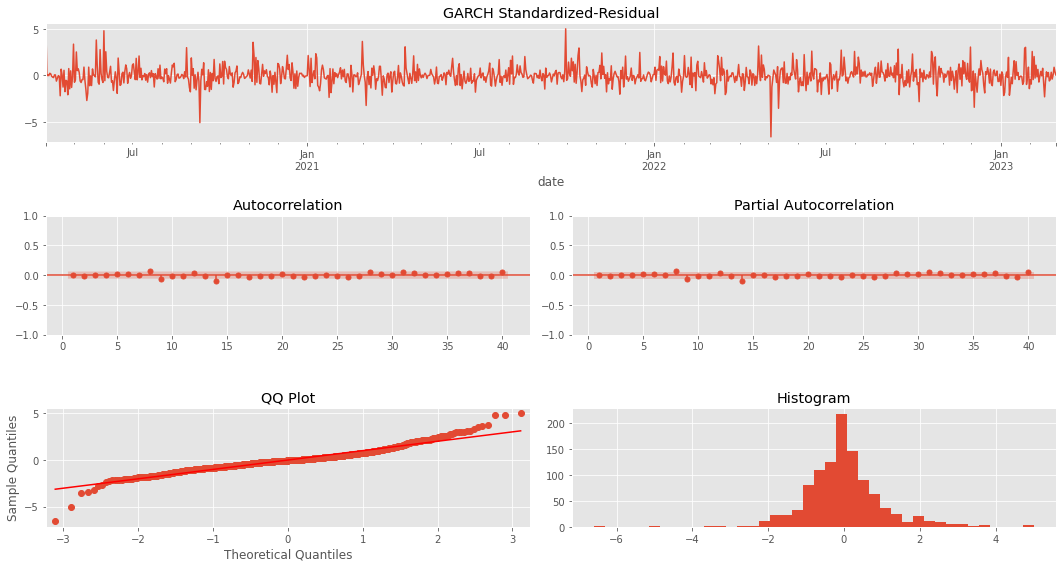

In [77]:
garch_std_resid = pd.Series(arima_garch.resid / arima_garch.conditional_volatility)
fig = plt.figure(figsize = (15, 8))

# Residual
garch_std_resid.plot(ax = fig.add_subplot(3,1,1), title = 'GARCH Standardized-Residual', legend = False)

# ACF/PACF
plot_acf(garch_std_resid, zero = False, lags = 40, ax = fig.add_subplot(3,2,3))
plot_pacf(garch_std_resid, zero = False, lags = 40, ax = fig.add_subplot(3,2,4))

# QQ-Plot & Norm-Dist
qqplot(garch_std_resid, line = 's', ax = fig.add_subplot(3,2,5)) 
plt.title("QQ Plot")
fig.add_subplot(3,2,6).hist(garch_std_resid, bins = 40)
plt.title("Histogram")

plt.tight_layout()
plt.show()

In [78]:
white_noise_garch = acorr_ljungbox(garch_std_resid, lags = [10], return_df=True)
white_noise_garch

,lb_stat,lb_pvalue
10,9.537299,0.48198


By the residual diagnostic tests above, we can conclude that the residual follows the normal distribution and is a white noise. Therefore, no explanatory variable can be taken.

### ARIMAX(4,1,0,'IDR/USD')

Even though we have noticed that ARIMA's residuals is not random from Ljung-Box test, we **can not conclude yet** that there exists **heteroskedasticity** effect. Thus, we will perform LM test to check it.

$H_0$： ARCH Effect not exists

$H_1$：ARCH Effect exists

In [79]:
LM_pvalue = het_arch(arimax_resid, ddof = 4)[1]
print(f'LM-test-Pvalue: {LM_pvalue}')

LM-test-Pvalue: 0.0034062378942697836


Since we got that p-value $\approx$ 0, then we **reject our null hypothesis**, and conclude that there exists a GARCH effect.

Now, we will **look** for the **p, q parameters** for the model **iteratively**, by observing the significancy of parameters of each possible values of p, q.

In [80]:
mdl_garchx = arch_model(arimax_resid, vol = 'GARCH', p = 1, q = 1)
arimax_garch = mdl_garchx.fit()
arimax_garch.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31253.540022708214
Iteration:      2,   Func. Count:     12,   Neg. LLF: 6445.133326420431
Iteration:      3,   Func. Count:     18,   Neg. LLF: 8954.798407462655
Iteration:      4,   Func. Count:     24,   Neg. LLF: 6407.839222569042
Iteration:      5,   Func. Count:     30,   Neg. LLF: 6418.518357631515
Iteration:      6,   Func. Count:     36,   Neg. LLF: 6381.185980988208
Iteration:      7,   Func. Count:     42,   Neg. LLF: 6376.663119904975
Iteration:      8,   Func. Count:     47,   Neg. LLF: 6376.551932494517
Iteration:      9,   Func. Count:     52,   Neg. LLF: 6376.405009870459
Iteration:     10,   Func. Count:     57,   Neg. LLF: 6376.403977850939
Iteration:     11,   Func. Count:     62,   Neg. LLF: 6376.4036026309195
Iteration:     12,   Func. Count:     67,   Neg. LLF: 6376.4012403469005
Iteration:     13,   Func. Count:     72,   Neg. LLF: 6376.388245325685
Iteration:     14,   Func. Count:     77,   Neg. LLF: 6376.32

C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.024e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6367.60
Distribution:                  Normal   AIC:                           12743.2
Method:            Maximum Likelihood   BIC:                           12763.1
                                        No. Observations:                 1064
Date:                Fri, Mar 03 2023   Df Residuals:                     1063
Time:                        09:50:34   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             4.4960      3.054      1.472      0.141 [ -1.491, 10.482]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega       3114.7201   3162.503      0.985      0.325 [-3.084e+03,9.313e+03]
alpha[1]       0.0756  3.936e-02      1.919  5.494e-02   [-1.597e-03,  0.153]
beta[1]        0.5720      0.342      1.674  9.407e-02   [-9.758e-02,  1.242]
=============================================================================

Covariance estimator: robust
"""

We notice that the only model with **significant parameters** is **GARCH(1,1)**. Thus, we will combine it with our base ARIMAX model.

**Residual Diagnosis**

C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


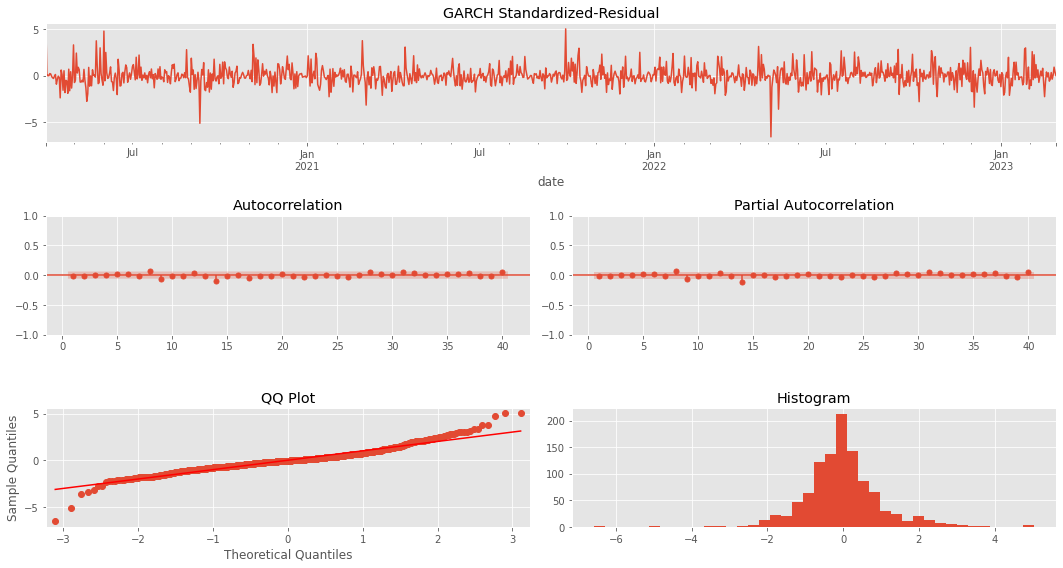

In [81]:
garch_std_resid = pd.Series(arimax_garch.resid / arimax_garch.conditional_volatility)
fig = plt.figure(figsize = (15, 8))

# Residual
garch_std_resid.plot(ax = fig.add_subplot(3,1,1), title = 'GARCH Standardized-Residual', legend = False)

# ACF/PACF
plot_acf(garch_std_resid, zero = False, lags = 40, ax = fig.add_subplot(3,2,3))
plot_pacf(garch_std_resid, zero = False, lags = 40, ax = fig.add_subplot(3,2,4))

# QQ-Plot & Norm-Dist
qqplot(garch_std_resid, line = 's', ax = fig.add_subplot(3,2,5)) 
plt.title("QQ Plot")
fig.add_subplot(3,2,6).hist(garch_std_resid, bins = 40)
plt.title("Histogram")

plt.tight_layout()
plt.show()

In [82]:
white_noise_garch = acorr_ljungbox(garch_std_resid, lags = [10], return_df=True)
white_noise_garch

,lb_stat,lb_pvalue
10,9.453185,0.489701


By the residual diagnostic tests above, we can conclude that the residual follows the normal distribution and is a white noise. Therefore, no explanatory variable can be taken.

## CNN & LSTM

### 3-D Format Conversion

We need to convert the data into 3-D format so that it can be processed using CNN method.

In [83]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
    
        # find the end of this pattern
        end_ix = i + n_steps

        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break

        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [84]:
n_steps = 7

X_bbca, y_bbca = split_sequence(bbca_info.values, n_steps)

In [85]:
# transform input from [samples, features] to [samples, timesteps, features]
X_bbca = X_bbca.reshape((X_bbca.shape[0], X_bbca.shape[1], 1))
print("BBCA shape : ", X_bbca.shape)

BBCA shape :  (1061, 3, 1)


### Split Dataset

In [86]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into two dataset
    train, test = data[:int(0.75 * len(data))], data[int(0.75 * len(data)):]
    
    return train, test

In [87]:
X_train_bbca, X_test_bbca = split_dataset(X_bbca)
y_train_bbca, y_test_bbca = split_dataset(y_bbca)

In [88]:
print("BBCA Dataset")
print("X_train shape : ", X_train_bbca.shape)
print("X_test shape : ", X_test_bbca.shape)
print("y_train shape : ", y_train_bbca.shape)
print("y_test shape : ", y_test_bbca.shape)

BBCA Dataset
X_train shape :  (795, 3, 1)
X_test shape :  (266, 3, 1)
y_train shape :  (795, 1)
y_test shape :  (266, 1)


### Change to Supervised

We will convert the TS data into Supervised data.

In [89]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out = 7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out

        # ensure we have enough data for this instance
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])

        # move along one time step
        in_start += 1
    
    return np.array(X), np.array(y)

### Model

In [90]:
# Train the model
def build_model(dl_model, train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    
    # define parameters
    verbose, epochs, batch_size = 1, 100, 4
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

    # define model
    if dl_model == 'CNN':
        model = Sequential()
        model.add(Conv1D(filters = 16, 
                         kernel_size = 3, 
                         activation = 'relu',
                         input_shape = (n_timesteps, n_features)))
        model.add(MaxPooling1D(pool_size = 2))
        model.add(Flatten())
        model.add(Dense(10, 
                        activation = 'relu'))
        model.add(Dense(n_outputs))
        model.compile(loss = 'mse', 
                      optimizer = 'adam')

        # fit network
        model.fit(train_x, train_y, epochs = epochs, batch_size = batch_size, verbose = verbose)
        
        return model
        
    elif dl_model == 'LSTM':
        model = Sequential()
        model.add(LSTM(200, 
                       activation = 'relu', 
                       input_shape = (n_timesteps, n_features)))
        model.add(Dense(100, 
                        activation = 'relu'))
        model.add(Dense(n_outputs))
        model.compile(loss = 'mse',
                      optimizer = 'adam')

        # fit network
        model.fit(train_x, train_y, epochs = epochs, batch_size = batch_size, verbose = verbose)

        return model

### Forecast Function

As CNN do not have an in-built forecasting function, we have to make it manually.

In [91]:
# Make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))

    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
  
    # we only want the vector forecast
    yhat = yhat[0]
    
    return yhat

In [ ]:
# Evaluate Forecasting
def evaluate_forecasts(actual, predicted):
    scores = list()
    
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
    
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])

        # calculate rmse
        rmse = np.sqrt(mse)

        # store
        scores.append(rmse)
  
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
            
    return score, scores

In [92]:
# Evaluate a single model
def evaluate_model(dl_model, train, test, n_input):
    # fit model
    model = build_model(dl_model, train, n_input)
    
    # history is a list of weekly data
    history = [x for x in train]
  
    # walk-forward validation over each week
    predictions = list()
  
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, 
                                 history,
                                 n_input)
    
        # store the predictions
        predictions.append(yhat_sequence)
    
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
  
    # evaluate predictions days for each week
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], 
                                       predictions)

    return predictions, score, scores

In [93]:
# Summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    
    print('%s: [%.3f] %s' % (name, score, s_scores))

### Result

In [95]:
# Split into train and test
train, test = split_dataset(bbca_info.values)

# Make into 3D
train, dummy1 = split_sequence(train, 7)
test, dummy2 = split_sequence(test, 7)

In [96]:
# Evaluate model and get scores
n_input = 7
predictions_cnn, score_cnn, scores_cnn = evaluate_model('CNN', train, test, 7)

# Summarize scores
summarize_scores('CNN', 
                 score_cnn, 
                 scores_cnn)

Epoch 1/100
1105/1105 [==============================] - 2s 1ms/step - loss: 3719216.2500
Epoch 2/100
1105/1105 [==============================] - 1s 1ms/step - loss: 8309.0244
Epoch 3/100
1105/1105 [==============================] - 1s 1ms/step - loss: 8411.3594
Epoch 4/100
1105/1105 [==============================] - 1s 1ms/step - loss: 8621.1113
Epoch 5/100
1105/1105 [==============================] - 1s 1ms/step - loss: 8784.9824
Epoch 6/100
1105/1105 [==============================] - 1s 1ms/step - loss: 8846.6074
Epoch 7/100
1105/1105 [==============================] - 1s 1ms/step - loss: 8865.9795
Epoch 8/100
1105/1105 [==============================] - 2s 1ms/step - loss: 8708.0771
Epoch 9/100
1105/1105 [==============================] - 2s 1ms/step - loss: 8798.2080
Epoch 10/100
1105/1105 [==============================] - 2s 1ms/step - loss: 8539.0518
Epoch 11/100
1105/1105 [==============================] - 1s 1ms/step - loss: 8397.9287
Epoch 12/100
1105/1105 [==============

1105/1105 [==============================] - 2s 2ms/step - loss: 7552.3008
Epoch 95/100
1105/1105 [==============================] - 2s 1ms/step - loss: 7567.3267
Epoch 96/100
1105/1105 [==============================] - 1s 975us/step - loss: 7551.6372
Epoch 97/100
1105/1105 [==============================] - 1s 1ms/step - loss: 7533.4795
Epoch 98/100
1105/1105 [==============================] - 1s 962us/step - loss: 7599.2397
Epoch 99/100
1105/1105 [==============================] - 1s 1ms/step - loss: 7441.0854
Epoch 100/100
1105/1105 [==============================] - 1s 1ms/step - loss: 7438.6245
CNN: [99.948] 70.7, 66.3, 53.9, 72.0, 110.4, 132.2, 150.9


In [100]:
# Evaluate model and get scores
n_input = 7
predictions_lstm, score_lstm, scores_lstm = evaluate_model('LSTM', train, test, 7)

# Summarize scores
summarize_scores('LSTM', 
                 score_lstm, 
                 scores_lstm)

Epoch 1/100
1105/1105 [==============================] - 7s 5ms/step - loss: 410349.8750
Epoch 2/100
1105/1105 [==============================] - 5s 5ms/step - loss: 10297.3047
Epoch 3/100
1105/1105 [==============================] - 5s 5ms/step - loss: 11577.5225
Epoch 4/100
1105/1105 [==============================] - 5s 5ms/step - loss: 11679.5771
Epoch 5/100
1105/1105 [==============================] - 5s 5ms/step - loss: 12368.3477
Epoch 6/100
1105/1105 [==============================] - 6s 5ms/step - loss: 10988.7500
Epoch 7/100
1105/1105 [==============================] - 5s 5ms/step - loss: 10661.0098
Epoch 8/100
1105/1105 [==============================] - 5s 5ms/step - loss: 10909.7227
Epoch 9/100
1105/1105 [==============================] - 5s 5ms/step - loss: 10580.6182
Epoch 10/100
1105/1105 [==============================] - 5s 5ms/step - loss: 10370.4736
Epoch 11/100
1105/1105 [==============================] - 6s 5ms/step - loss: 10132.4375
Epoch 12/100
1105/1105 [=====

1105/1105 [==============================] - 10s 9ms/step - loss: 6389.5591
Epoch 94/100
1105/1105 [==============================] - 9s 9ms/step - loss: 6512.6763
Epoch 95/100
1105/1105 [==============================] - 10s 9ms/step - loss: 6471.0981
Epoch 96/100
1105/1105 [==============================] - 12s 11ms/step - loss: 6578.8013
Epoch 97/100
1105/1105 [==============================] - 11s 10ms/step - loss: 6291.6655
Epoch 98/100
1105/1105 [==============================] - 12s 11ms/step - loss: 6445.4565
Epoch 99/100
1105/1105 [==============================] - 12s 11ms/step - loss: 6404.7280
Epoch 100/100
1105/1105 [==============================] - 12s 11ms/step - loss: 6323.8965
LSTM: [80.167] 92.0, 89.5, 67.9, 66.1, 67.8, 37.0, 116.5


In [101]:
print(f'By using the CNN model, we get that the RMSE is {score_cnn}')
print(f'By using the LSTM model, we get that the RMSE is {score_lstm}')

By using the CNN model, we get that the RMSE is 99.94806251086776
By using the LSTM model, we get that the RMSE is 80.1666281989996


# Forecasting

**Note**: In this analytics, the prediction and forecasting will only performed on the 'conventional', which is the ARIMA, ARIMAX, and SARIMA model, and will not be performed on the GARCH model.

## Prediction

### ARIMA(4,1,0)

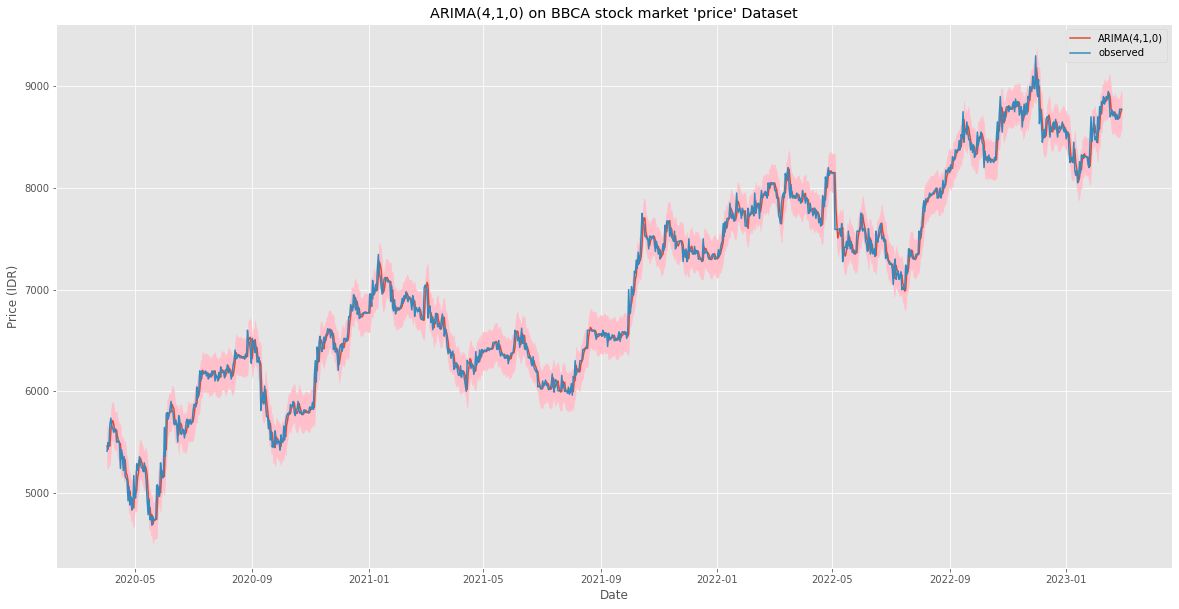

In [115]:
# Create ARIMA mean forecast
arima_pred = arima_model.get_prediction(start = '2020-04-02')
arima_mean = arima_pred.predicted_mean

# Get confidence intervals of ARIMA mean forecasts
conf_int_arima = arima_pred.conf_int()

# Plot mean ARIMA predictions and observed
plt.figure(figsize = (20,10))

plt.plot(arima_mean.index, 
         arima_mean, 
         label = 'ARIMA(4,1,0)')

plt.fill_between(conf_int_arima.index, 
                 conf_int_arima['lower close'], 
                 conf_int_arima['upper close'], 
                 color = 'pink')

plt.plot(bbca_info['2020-04-02':], 
         label = 'observed')

plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.title('ARIMA(4,1,0) on BBCA stock market \'price\' Dataset')
plt.legend()
plt.show()

### ARIMAX(4,1,0,'IDR/USD')

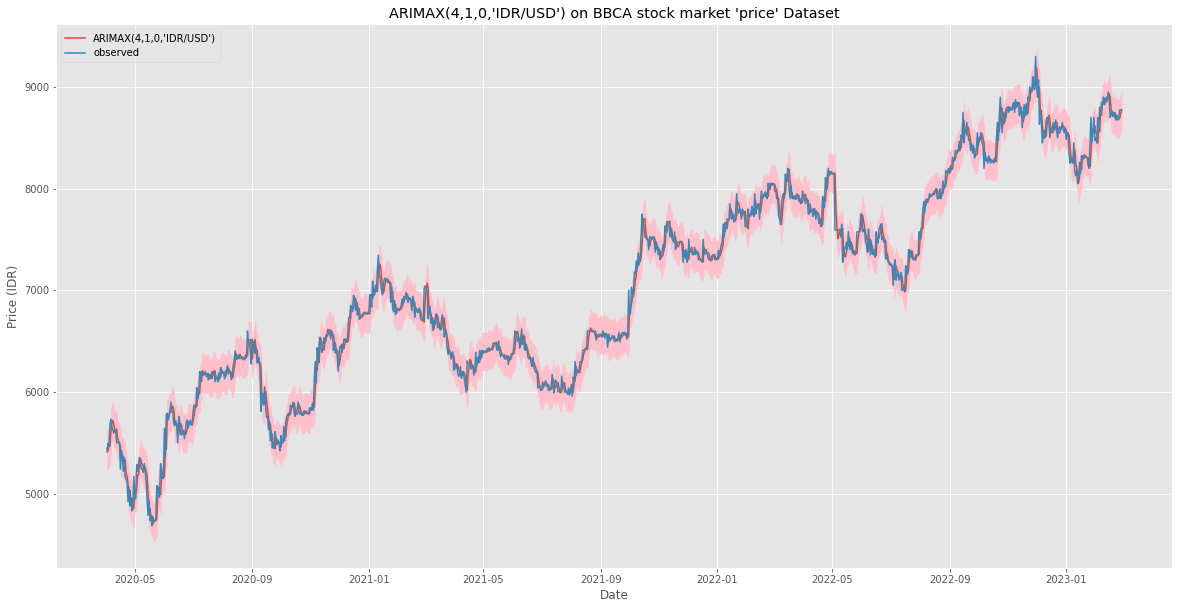

In [116]:
# ARIMAX

# Create ARIMAX mean forecast
arimax_pred = arimax_model.get_prediction(start = '2020-04-02')
arimax_mean = arimax_pred.predicted_mean

# Get confidence intervals of ARIMAX mean forecasts
conf_int_arimax = arimax_pred.conf_int()

# Plot mean ARIMAX predictions and observed
plt.figure(figsize = (20,10))

plt.plot(arimax_mean.index, 
         arimax_mean, 
         label = 'ARIMAX(4,1,0,\'IDR/USD\')')

plt.fill_between(conf_int_arimax.index, 
                 conf_int_arimax['lower close'], 
                 conf_int_arimax['upper close'],
                 color = 'pink')

plt.plot(bbca_info['2020-04-02':], 
         label = 'observed')

plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.title('ARIMAX(4,1,0,\'IDR/USD\') on BBCA stock market \'price\' Dataset')
plt.legend()
plt.show()

### SARIMA(1,1,1)x(0,1,1,12)

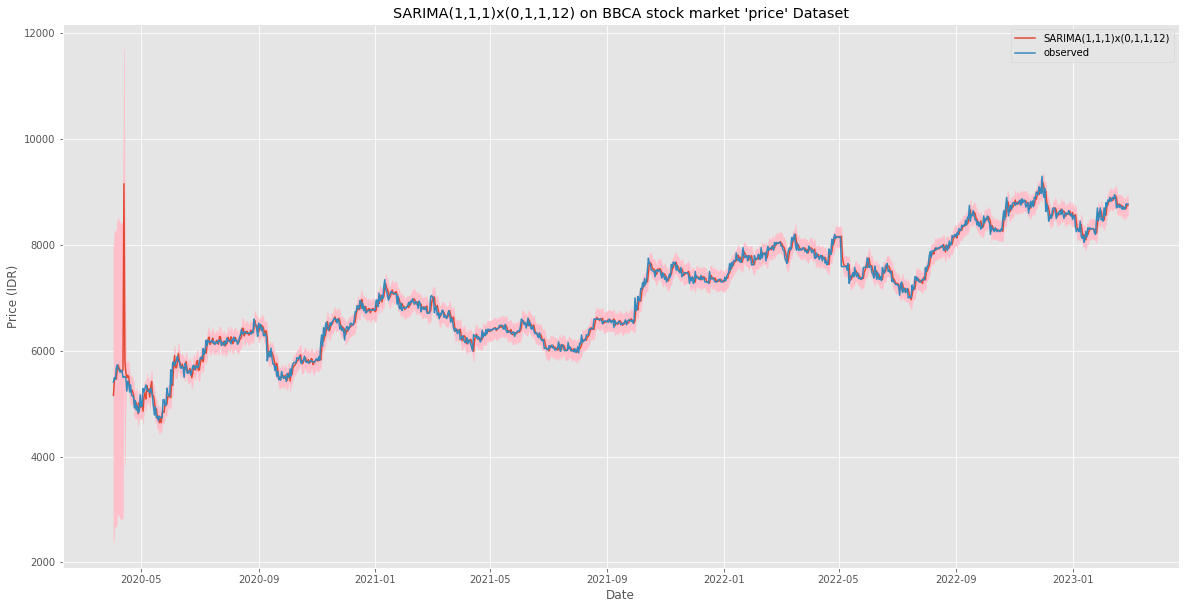

In [117]:
# SARIMA

# Create SARIMA mean forecast
sarima_pred = sarima_model.get_prediction(start = '2020-04-02')
sarima_mean = sarima_pred.predicted_mean

# Get confidence intervals of SARIMA mean forecasts
conf_int_sarima = sarima_pred.conf_int()

# Plot mean ARIMAX predictions and observed
plt.figure(figsize = (20,10))

plt.plot(sarima_mean.index, 
         sarima_mean, 
         label = 'SARIMA(1,1,1)x(0,1,1,12)')

plt.fill_between(conf_int_sarima.index, 
                 conf_int_sarima['lower close'], 
                 conf_int_sarima['upper close'],
                 color = 'pink')

plt.plot(bbca_info['2020-04-02':], 
         label = 'observed')

plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.title('SARIMA(1,1,1)x(0,1,1,12) on BBCA stock market \'price\' Dataset')
plt.legend()
plt.show()

### ARIMA(4,1,0)-GARCH(1,1)

In [118]:
# test_size = len(bbca_info.values)
# arima_garch.forecast(horizon = test_size).variance

### ARIMAX(4,1,0,'IDR/USD')-GARCH(1,1)

## RMSE

In [119]:
y_bbca = bbca_info['2020-04-02':]

# Prediction for all models
yhat_1_bbca = arima_model.get_prediction(start = '2020-04-02').predicted_mean
yhat_2_bbca = arimax_model.get_prediction(start = '2020-04-02').predicted_mean
yhat_3_bbca = sarima_model.get_prediction(start = '2020-04-02').predicted_mean

# Print MSE
print("MSE for ARIMA(4,1,0) prediction : ", mean_squared_error(y_bbca, yhat_1_bbca))
print("MSE for ARIMAX(4,1,0,'IDR/USD') prediction : ", mean_squared_error(y_bbca, yhat_2_bbca))
print("MSE for SARIMA(1,1,1)x(0,1,1,12) prediction : ", mean_squared_error(y_bbca, yhat_3_bbca))

MSE for ARIMA(4,1,0) prediction :  8991.787790754379
MSE for ARIMAX(4,1,0,'IDR/USD') prediction :  8956.183159765582
MSE for SARIMA(1,1,1)x(0,1,1,12) prediction :  22560.370671303524


## Model Summary

In [120]:
# Cetak Root Mean Square
rmse_1 = np.sqrt(mean_squared_error(y_bbca, yhat_1_bbca))
rmse_2 = np.sqrt(mean_squared_error(y_bbca, yhat_2_bbca))
rmse_3 = np.sqrt(mean_squared_error(y_bbca, yhat_3_bbca))
rmse_4 = score_cnn
rmse_5 = score_lstm

rmse = [rmse_1, rmse_2, rmse_3, rmse_4, rmse_5]

# Cetak Nama Model
model = ['ARIMA(3,1,1)', 'ARIMAX(3,1,1,\'IDR/USD\')', 'SARIMA(1,1,1)x(0,1,1,12)', 
         'Convolutional Neural Network', 'Long Short-Term Memory']

# Buat dictionary
dict_data_bbca = {'Nama Model': model,
                  'RMSE' : rmse}

# Buat DataFramenya
df_score_bbca = pd.DataFrame(dict_data_bbca).sort_values(by = 'RMSE', 
                                                         ascending = True).reset_index(drop = True)

df_score_bbca

,Nama Model,RMSE
0,Long Short-Term Memory,80.166628
1,"ARIMAX(3,1,1,'IDR/USD')",94.637113
2,"ARIMA(3,1,1)",94.825038
3,Convolutional Neural Network,99.948063
4,"SARIMA(1,1,1)x(0,1,1,12)",150.201101


### Final Best Model

Based on the AIC-BIC, Diagnostic Test, and also the RMSE results, we can conclude that:

1. ____
2. ____
3. ____
4. ____
5. ____

respectively, are the **best models** for our BBCA dataset since they are **statistically significance** and have the **lowest AIC-BIC** and **lowest RMSE**.

We will see the forecasted result for each models.

## Forecasting

In [121]:
def forecast_time_series(data, model_result, n_steps, predicted_date, exog = None, exog_name = None, result = False):
    arimax_pred = model_result.get_forecast(steps = n_steps,
                                            # A week is chosen as forecasting for a long term 
                                            # is not wise and will certainly lead to a high bias/low confidence level
                                            exog = exog_idr_usd[-1:-n_steps-1:-1], 
                                            dynamic = True)

    arimax_mean = pd.DataFrame(arimax_pred.predicted_mean)
    arimax_mean.index = predicted_date
    arimax_mean.columns = ['close']

    arimax_mean = pd.concat([data, arimax_mean], axis = 0)

    # Get confidence intervals of ARIMAX(1,1,0,'IDR/USD') mean forecasts
    conf_int_arimax = arimax_pred.conf_int()
    conf_int_arimax.index = predicted_date


    if result == False:
        # Plot mean ARIMAX predictions and observed
        plt.figure(figsize = (20,10))

        plt.plot(arimax_mean[start_date:], 
                 label = f'Prediction ARIMAX(4,1,0,{exog_name}))', 
                 color = 'red')

        plt.fill_between(conf_int_arimax.index, 
                         conf_int_arimax['lower close'], 
                         conf_int_arimax['upper close'], 
                         label = None,
                         color = 'pink')

        plt.plot(data[start_date:], 
                 label = 'observed', 
                 color = 'blue')

        plt.xlabel('Date')
        plt.ylabel('Price (IDR)')
        plt.title(f'ARIMAX(4,1,0,{exog_name}) on BBCA stock market prediction \'price\' in the next 7 days')
        plt.legend()
        plt.show()
        pass
        
    else:
        conf_int_arimax['close'] = arimax_mean['close'][-n_steps::1]
        conf_int_arimax = conf_int_arimax[['lower close', 'close', 'upper close']]
        return conf_int_arimax

In [122]:
# Start observing date
start_date = '2021-12-01'

# Start predicted date
x = '2023-03-01'
predicted_dates = pd.date_range(start = dt.datetime.strptime(x, '%Y-%m-%d'), 
                                end = (dt.datetime.strptime(x, '%Y-%m-%d') + dt.timedelta(days = 6)).strftime('%Y-%m-%d'))

In [123]:
predicted_dates

DatetimeIndex(['2023-03-01', '2023-03-02', '2023-03-03', '2023-03-04',
               '2023-03-05', '2023-03-06', '2023-03-07'],
              dtype='datetime64[ns]', freq='D')

### ARIMA(4,1,0)

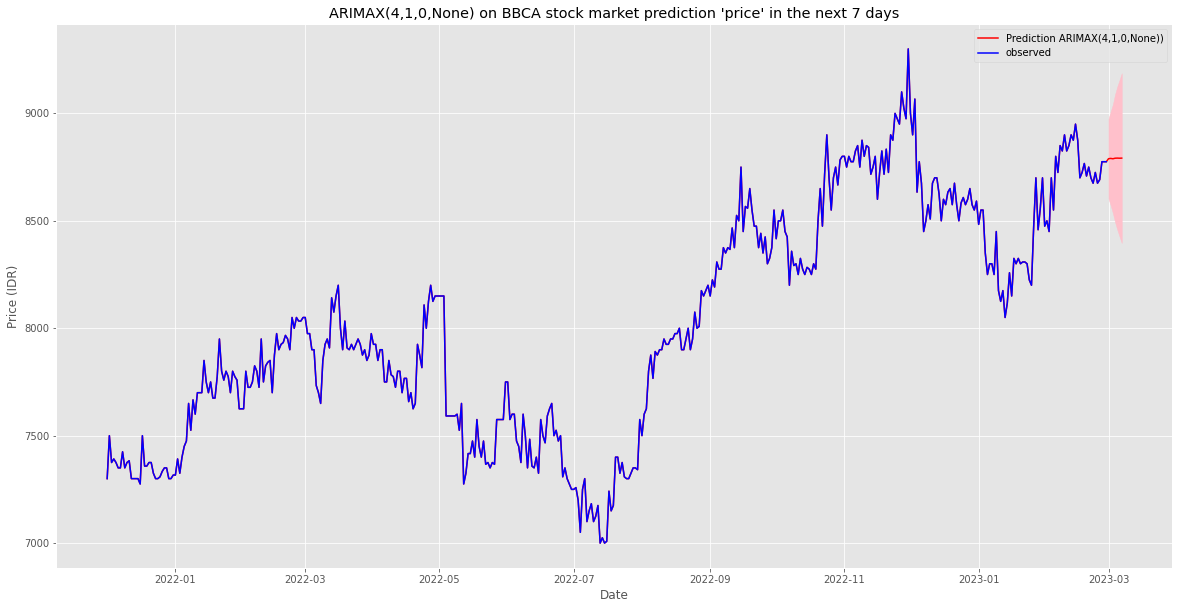

In [124]:
forecast_time_series(data = bbca_info, 
                     model_result = arima_model, 
                     n_steps = 7, 
                     exog = None, 
                     exog_name = None, 
                     predicted_date = predicted_dates, 
                     result = False)

In [125]:
# ARIMA(4,1,0) Prediction
result_1 = forecast_time_series(data = bbca_info, 
                                model_result = arima_model, 
                                n_steps = 7, 
                                exog = None, 
                                exog_name = None, 
                                predicted_date = predicted_dates, 
                                result = True)

result_1

,lower close,close,upper close
2023-03-01,8603.286165,8788.973350,8974.660535
2023-03-02,8571.337393,8790.319928,9009.302464
2023-03-03,8535.306772,8788.712435,9042.118097
2023-03-04,8493.271416,8791.331017,9089.390617
2023-03-05,8458.513599,8791.784886,9125.056173
2023-03-06,8427.442441,8791.270363,9155.098285
2023-03-07,8396.963299,8791.698110,9186.432921


### ARIMAX(4,1,0,'IDR/USD')

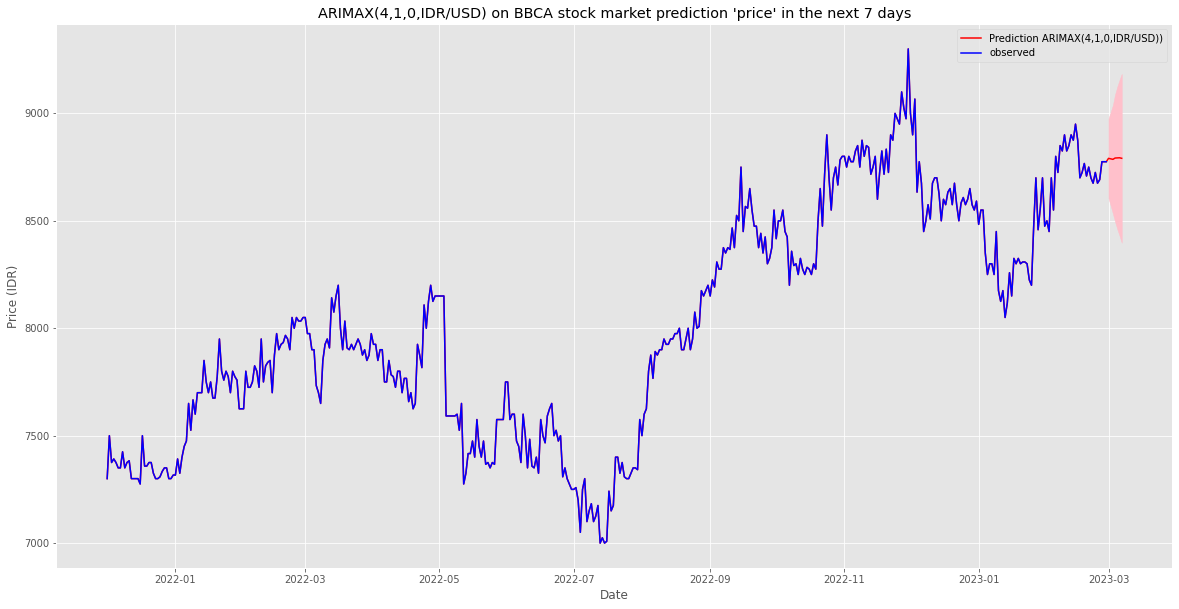

In [126]:
forecast_time_series(data = bbca_info, 
                     model_result = arimax_model, 
                     n_steps = 7, 
                     exog = exog_idr_usd, 
                     exog_name = 'IDR/USD', 
                     predicted_date = predicted_dates, 
                     result = False)

In [127]:
# ARIMAX(4,1,0,'IDR/USD') Prediction
result_2 = forecast_time_series(data = bbca_info, 
                                model_result = arimax_model, 
                                n_steps = 7, 
                                exog = exog_idr_usd, 
                                exog_name = 'IDR/USD', 
                                predicted_date = predicted_dates, 
                                result = True)

result_2

,lower close,close,upper close
2023-03-01,8605.289394,8790.637801,8975.986209
2023-03-02,8569.787936,8788.207125,9006.626314
2023-03-03,8533.447168,8786.035150,9038.623131
2023-03-04,8495.163602,8792.130854,9089.098106
2023-03-05,8460.950994,8792.714187,9124.477380
2023-03-06,8431.272431,8793.340984,9155.409537
2023-03-07,8398.196622,8790.895806,9183.594989


### SARIMA(1,1,1)x(0,1,1,12)

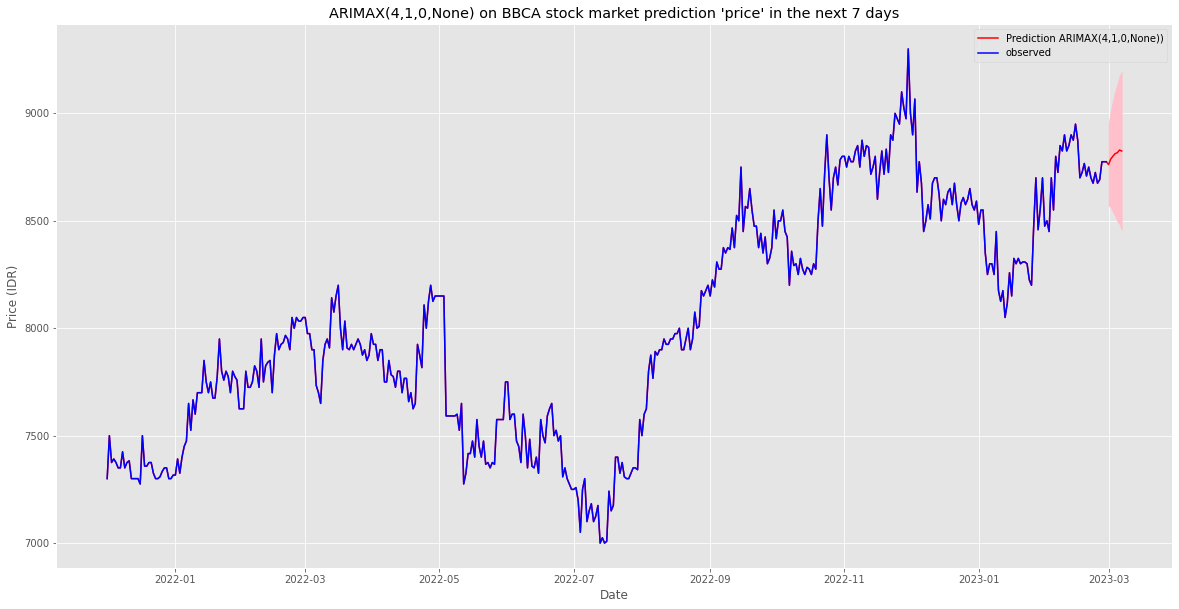

In [128]:
forecast_time_series(data = bbca_info, 
                     model_result = sarima_model, 
                     n_steps = 7, 
                     exog = None, 
                     exog_name = None, 
                     predicted_date = predicted_dates, 
                     result = False)

In [129]:
# SARIMA(1,1,1)x(0,1,1,12) Prediction
result_3 = forecast_time_series(data = bbca_info, 
                                model_result = sarima_model, 
                                n_steps = 7, 
                                exog = None, 
                                exog_name = None, 
                                predicted_date = predicted_dates, 
                                result = True)

result_3

,lower close,close,upper close
2023-03-01,8571.006104,8761.458626,8951.911148
2023-03-02,8562.338904,8787.318544,9012.298184
2023-03-03,8539.675832,8800.631695,9061.587558
2023-03-04,8521.042649,8812.598107,9104.153565
2023-03-05,8497.262874,8816.655908,9136.048943
2023-03-06,8484.443379,8829.409267,9174.375155
2023-03-07,8456.038790,8824.812483,9193.586176


### ARIMA(4,1,0)-GARCH(1,1)

### ARIMAX(4,1,0,'IDR/USD')-GARCH(1,1)

**Convolutional Neural Network**

In [138]:
predictions_lstm[-1]

array([8748.291, 8743.621, 8678.797, 8720.265, 8712.184, 8750.201,
       8725.27 ], dtype=float32)

**Long Short-Term Memory**

## Conclusion

Based on our model, we can see that for the **next 7 days**, we can expect that the **BBCA stock market price** will be have a decrement trend from **7600 IDR to 7450 IDR**, and a **margin error of ~6.3%**.

## Recommendation

**Technical**

---

A better and validated result can probably be obtained by **comparing the model** using more **advance forecasting model**, such as **ARCH/GARCH**. Or even better, a **combined ARIMA-GARCH model**, where we use ARIMA to predict the mean and GARCH to predict the variance of future values.

**Non-technical**

---

The BBCA stock market price do not show any sign of dropping anytime soon. So, if you are a **shareholder**, try **not to sell your stock**, except in case of emergencies. And for a **non-shareholder**, you probably want to **wait** when the price is showing a **decrement trend**, which is **probably** not in the near future (1-week time).

# Bonus: Portfolio Optimization

Since the author is still an Undergraduate student which do not possess a large sum of money, we want to **minimize the risk of losing money**. Thus, here we will optimize our Portfolio by using **Mean Conditional Value at Risk (mCVAR) algorithm**, which works by measuring the worst-case scenarios for each asset in the portfolio, and is represented here by losing the most money.

## Data Preparation

In [141]:
portfolio = pd.DataFrame()

portfolio.index = bbca_info.index

# Get BBCA and ^JKSE close value
portfolio['BBCA'] = bbca_info.values
jkse_info = jkse_info['2020-04-01':]
portfolio['^JKSE'] = jkse_info.values

portfolio

,BBCA,^JKSE
date,,
2020-04-01,5480.000000,4466.037109
2020-04-02,5410.000000,4531.685059
2020-04-03,5495.000000,4623.429199
2020-04-04,5461.666667,4540.383789
2020-04-05,5675.000000,4739.053711
...,...,...
2023-02-24,8675.000000,6856.576172
2023-02-25,8691.666667,6835.332682
2023-02-26,8775.000000,6854.776855


## Log Returns

In [145]:
log_returns = np.log(portfolio / portfolio.shift(1))
log_returns

,BBCA,^JKSE
date,,
2020-04-01,NaN,NaN
2020-04-02,-0.012856,0.014592
2020-04-03,0.015589,0.020043
2020-04-04,-0.006085,-0.018125
2020-04-05,0.038317,0.042826
...,...,...
2023-02-24,-0.005747,0.002500
2023-02-25,0.001919,-0.003103
2023-02-26,0.009542,0.002841


## Sharpe Ratio

In [160]:
n_portfolios = len(portfolio)
weight = np.zeros((n_portfolios, 2))

expectedReturn = np.zeros(n_portfolios)
expectedVolatility = np.zeros(n_portfolios)
sharpeRatio = np.zeros(n_portfolios)

meanLR = log_returns.mean()
S = log_returns.cov()
for k in range(n_portfolios):
    # Generate random weights for each portfolio
    w = np.random.random(2)
    w = w / np.sum(w)
    weight[k, :] = w
    
    # Expected return & volatility
    expectedReturn[k] = np.sum(meanLR * w)
    expectedVolatility[k] = np.sqrt(np.matmul(w.T, np.matmul(S, w)))
    
    # Sharpe Ratio
    sharpeRatio[k] = expectedReturn[k] / expectedVolatility[k]

In [161]:
maxIdx = sharpeRatio.argmax()
optWeight = weight[maxIdx, :]

maxIdx, optWeight

(131, array([0.00124345, 0.99875655]))

## Return vs Volatility

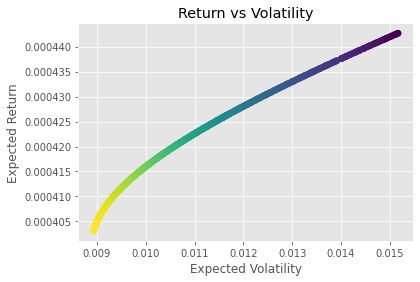

In [165]:
plt.scatter(expectedVolatility, expectedReturn, c = sharpeRatio)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Return vs Volatility')

plt.show()

## Optimization

In [142]:
mu = mean_historical_return(portfolio)

S = portfolio.cov()

ef_cvar = EfficientCVaR(mu, S)
cvar_weights = ef_cvar.min_cvar()

cleaned_weights = ef_cvar.clean_weights()
print(dict(cleaned_weights))

{'BBCA': 1.0, '^JKSE': 0.0}


In [143]:
# Get the latest value of each stock price
latest_prices = get_latest_prices(portfolio)

# Assuming that we have IDR 5 mio
da_cvar = DiscreteAllocation(cvar_weights, latest_prices, total_portfolio_value = 5e6)

allocation, leftover = da_cvar.greedy_portfolio()
print("Discrete allocation (CVAR):", allocation)
print("Funds remaining (CVAR): IDR {:.2f}".format(leftover))

Discrete allocation (CVAR): {'BBCA': 569, '^JKSE': 1}
Funds remaining (CVAR): IDR 170.22


Notice that using this algorithm, we are suggested to perform **all-out invest into BBCA** stockprice. It is logical since BBCA stockprice has an **increment trend and has multiplied 2.5 of its original price since it was first introduced**, and only had one spike drop, which happened during the early COVID-19 pandemic.